# Проект: Прогноз расхода энергии по временным рядам

## Цели проекта: 
## 1. Провести анализ данных о расходе энергии.
## 2. Посмотреть как менялись значения за прошедший период.
## 3. Сделать предсказание о расходе энергии на долгосрочный период.

In [294]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from warnings import filterwarnings
filterwarnings("ignore")
import statsmodels.graphics.tsaplots as sgt

from sklearn import metrics
from sklearn.metrics import mean_squared_error

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [295]:
#импорт файлов с данными
data = pd.read_csv('data/pjm_hourly_est.csv')
display(data.head())
data.info()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       121273 non-null  float64
 2   COMED     66497 non-null   float64
 3   DAYTON    121275 non-null  float64
 4   DEOK      57739 non-null   float64
 5   DOM       116189 non-null  float64
 6   DUQ       119068 non-null  float64
 7   EKPC      45334 non-null   float64
 8   FE        62874 non-null   float64
 9   NI        58450 non-null   float64
 10  PJME      145366 non-null  float64
 11  PJMW      143206 non-null  float64
 12  PJM_Load  32896 non-null   float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


In [296]:
# исследуем данные на предмет пропусков и дубликатов
print(data.isnull().sum())
data_dubl = data[data.duplicated()]
data = data.drop_duplicates()
data

Datetime         0
AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178257,2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
178258,2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
178259,2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
178260,2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN


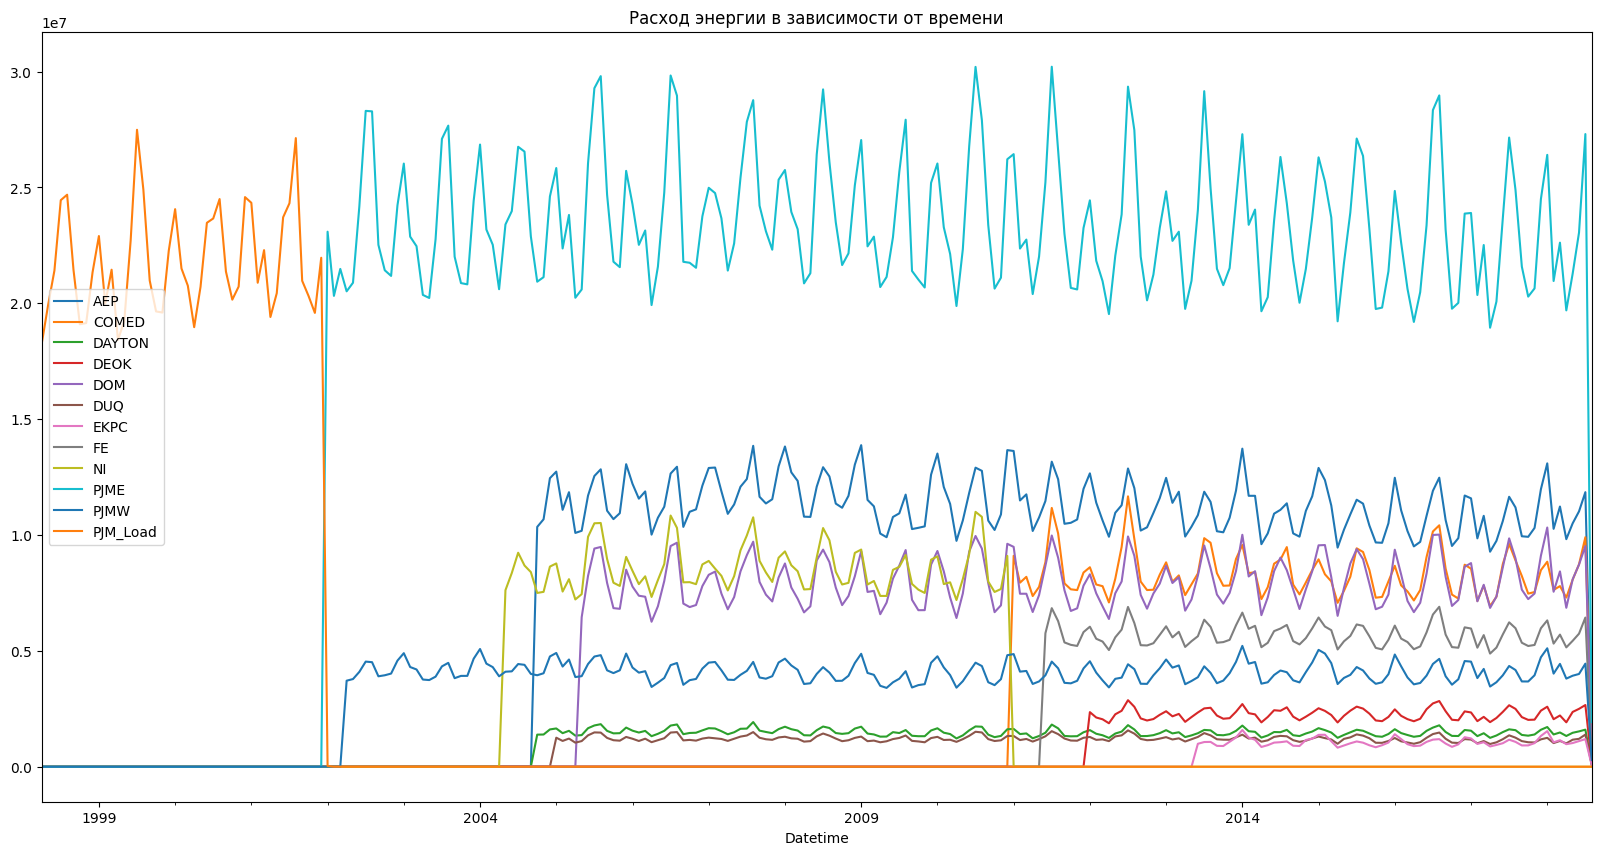

In [297]:
#поменяем формат даты и построим график для наших данных, сгруппируем по месяцам
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)
data_group = data.groupby(data['Datetime'].dt.to_period('M')).agg('sum')
plot = data_group.plot(legend=True, figsize=(20,10), title='Расход энергии в зависимости от времени');

Дубликаты отсутствуют.

В наших данных наблюдается много пропусков, так как исследования проводились в разное время и в разных местах.

По графику можно понять, что существует набор данных определенных на всем временном промежутке и количество затраченной энергии совпадает.
Можно сделать вывовод о том, что эти параметры измерены в одном месте, но в разные промежутки времени.
Их можно объединить в одну таблицу и исследовать на всем временном промежутке, чтобы проследить изменнения потребления энергии с 1998 по 2018 гг.

In [298]:
#объединим две таблицы с похожими данными в одну для дальнейшей работы
PJM = pd.read_csv('data/PJM_Load_hourly.csv', parse_dates=['Datetime'], index_col=['Datetime'])
PJME = pd.read_csv('data/PJME_hourly.csv', parse_dates=['Datetime'], index_col=['Datetime'])
PJM = PJM.rename(columns={'PJM_Load_MW':'PJME_MW'})
print(PJM.info(), PJME.info())
data_pjm =pd.concat([PJM, PJME])
data_pjm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-12-31 01:00:00 to 2001-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  32896 non-null  float64
dtypes: float64(1)
memory usage: 514.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  178262 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


In [299]:
#проверим наличие пропусков
display(data_pjm.isnull().sum())


PJME_MW    0
dtype: int64

## Часть 2:  Разведывательный анализ

         PJME_MW
count  178262.00
mean    31653.24
std      6418.19
min     14544.00
25%     27173.00
50%     31053.00
75%     35191.75
max     62009.00
Медианное значение: PJME_MW    31053.0
dtype: float64


<Axes: xlabel='PJME_MW', ylabel='Count'>

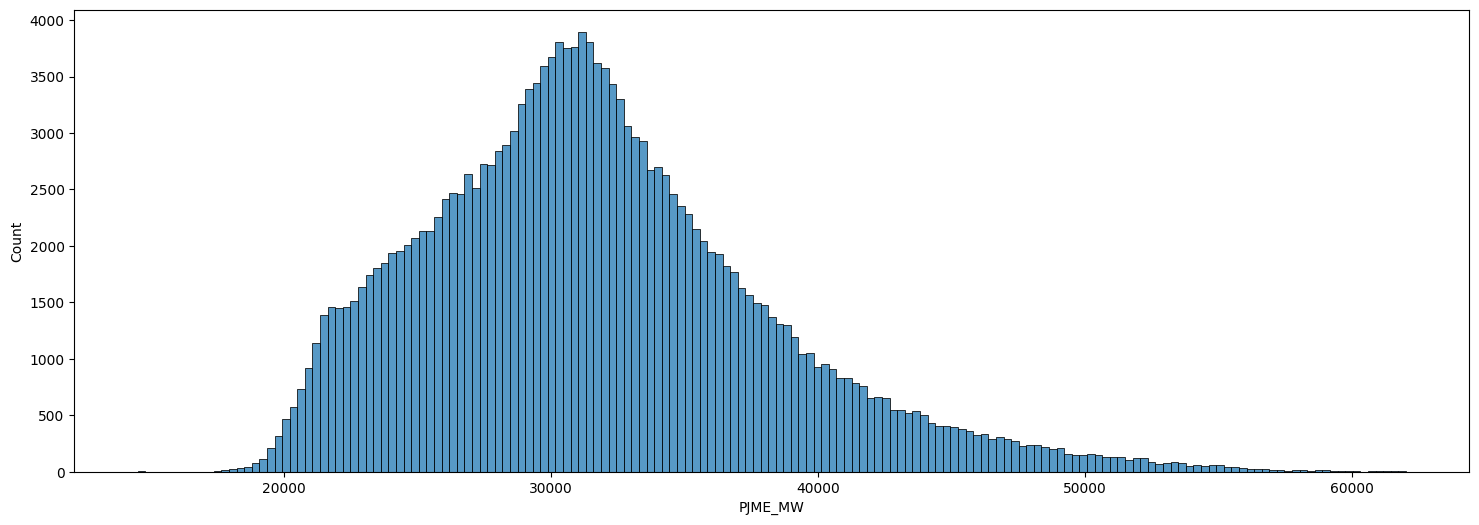

In [300]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(round(data_pjm.describe(),2))
print(f'Медианное значение: {round(data_pjm.median(),2)}')
plt.figure(figsize=(18,6))
sns.histplot(x=data_pjm['PJME_MW'])



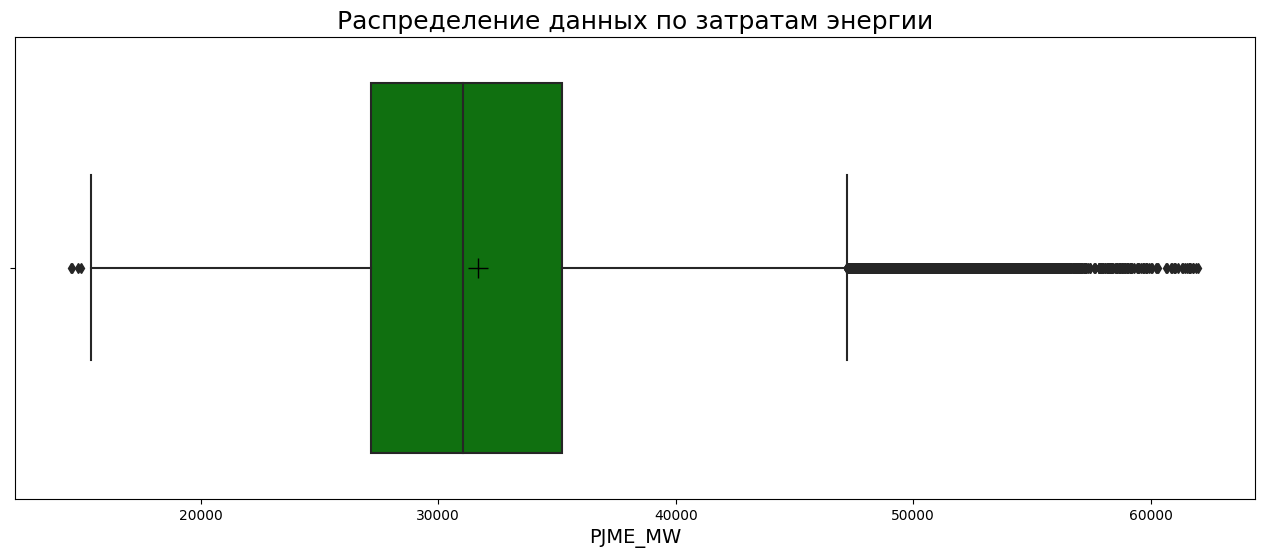

In [301]:
#посмотрим выбросы
plt.figure(figsize=(16, 6))
sns.boxplot(x=data_pjm['PJME_MW'], color='green', showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "14"})
plt.xlabel('PJME_MW', size=14)
plt.title('Распределение данных по затратам энергии', size=18);

In [302]:
#посчитаем значение по дням
data_pjm_day = data_pjm.resample('D').sum()
data_pjm_day.drop(labels=['2018-08-03'], axis=0, inplace=True) # последний день можно удалить, так как данные предоставлены за 1 час
data_pjm_day.tail(10)

,PJME_MW
Datetime,
2018-07-24,921189.0
2018-07-25,889492.0
2018-07-26,917308.0
2018-07-27,916596.0
2018-07-28,827898.0
2018-07-29,771910.0
2018-07-30,790978.0
2018-07-31,828938.0
2018-08-01,941539.0


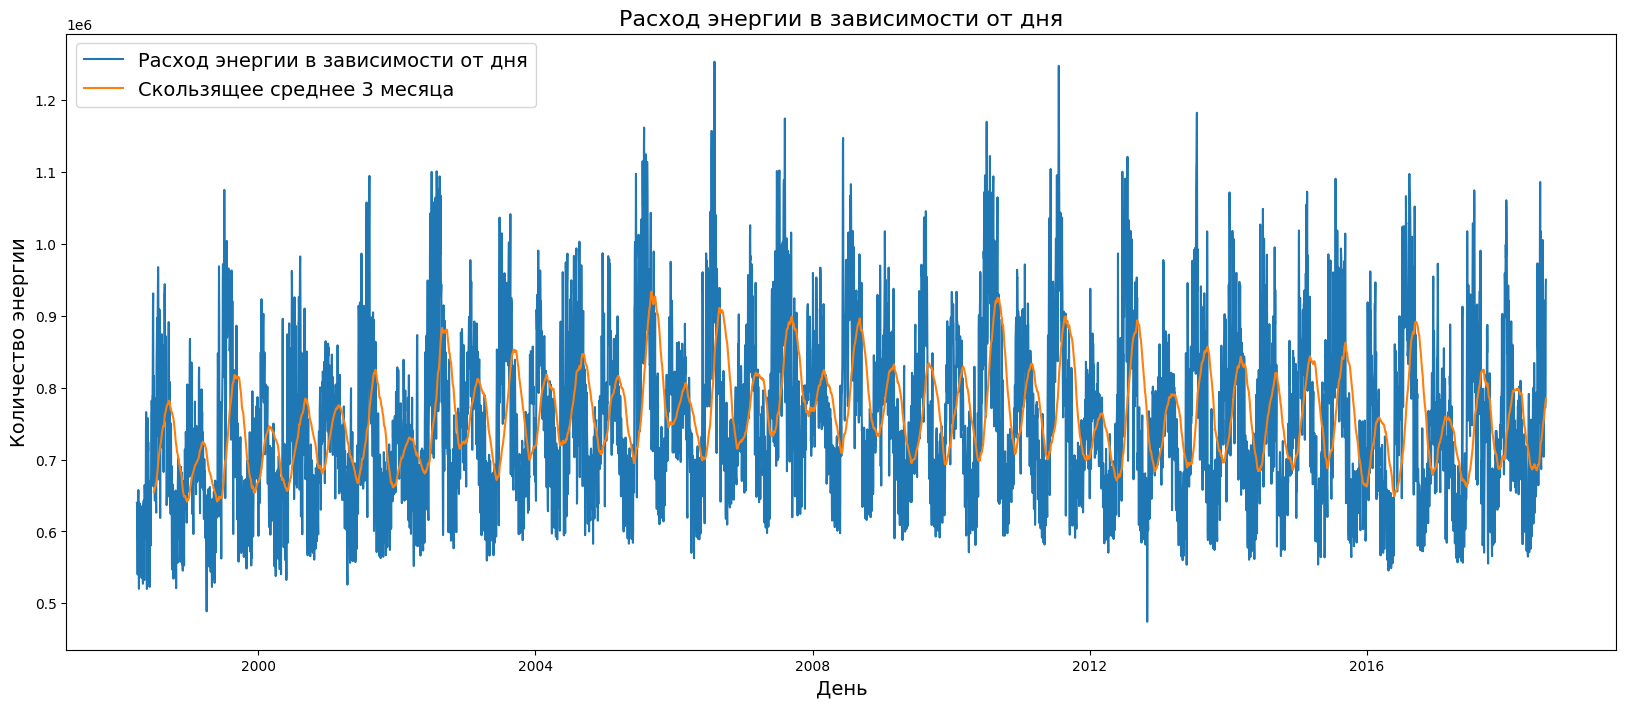

In [303]:
#посмотрим распределение расхода энергии по дням на графике со скользящим средним 3 месяца
plt.figure(figsize=(20,8))
plt.plot(data_pjm_day, label='Расход энергии в зависимости от дня')
plt.plot(data_pjm_day.rolling(window=91).mean(), label='Скользящее среднее 3 месяца')
plt.legend(title='', loc='upper left', fontsize=14)
plt.xlabel('День', fontsize=14)
plt.ylabel('Количество энергии', fontsize=14)
plt.title('Расход энергии в зависимости от дня', fontsize=16)
plt.show();

График скользящего среднего повторяет общую сезонность

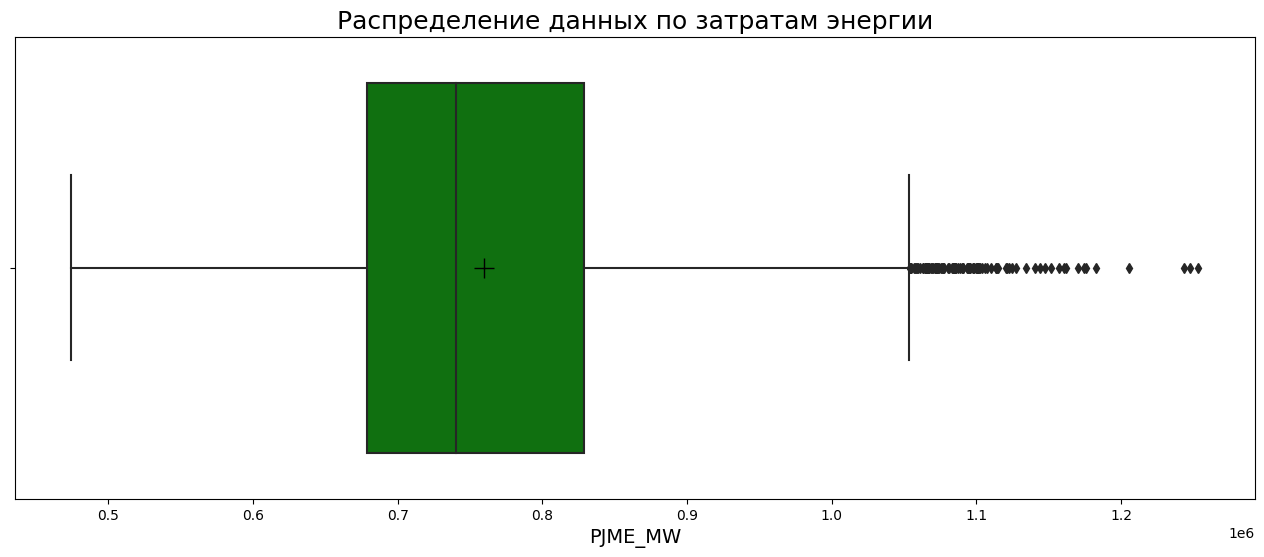

In [304]:
#посмотрим выбросы
plt.figure(figsize=(16, 6))
sns.boxplot(x=data_pjm_day['PJME_MW'], color='green', showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "14"})
plt.xlabel('PJME_MW', size=14)
plt.title('Распределение данных по затратам энергии', size=18);

In [305]:
#посчитаем значение по месяцам
data_pjm_month = data_pjm.resample('M').sum()
data_pjm_month.drop(labels=['2018-08-31'], axis=0, inplace=True) #последний месяц можно удалить, так как измерения всего за 3 дня
data_pjm_month.tail()

,PJME_MW
Datetime,
2018-03-31,22615842.0
2018-04-30,19694352.0
2018-05-31,21278364.0
2018-06-30,23050418.0
2018-07-31,27302373.0


            PJME_MW
count  2.440000e+02
mean   2.311739e+07
std    2.692850e+06
min    1.825820e+07
25%    2.095946e+07
50%    2.272838e+07
75%    2.470330e+07
max    3.020893e+07


<Axes: xlabel='PJME_MW', ylabel='Count'>

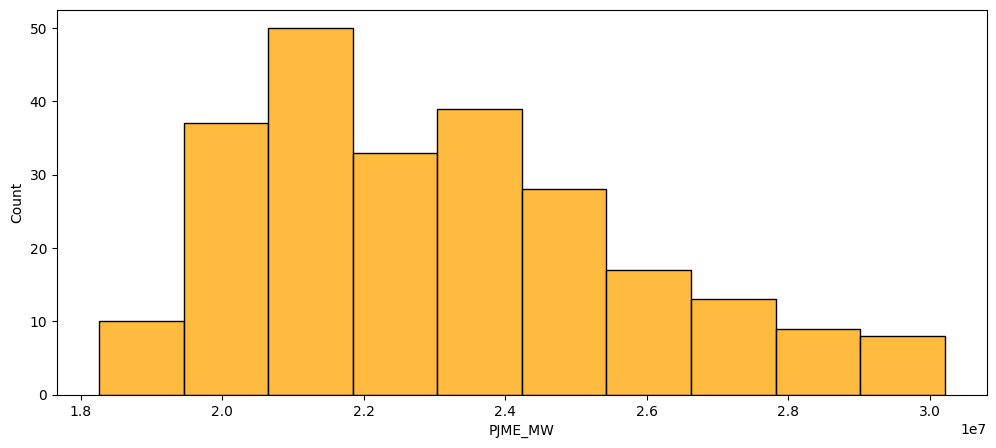

In [306]:
print(data_pjm_month.describe())
plt.figure(figsize=(12,5))
sns.histplot(x=data_pjm_month['PJME_MW'], color='orange')

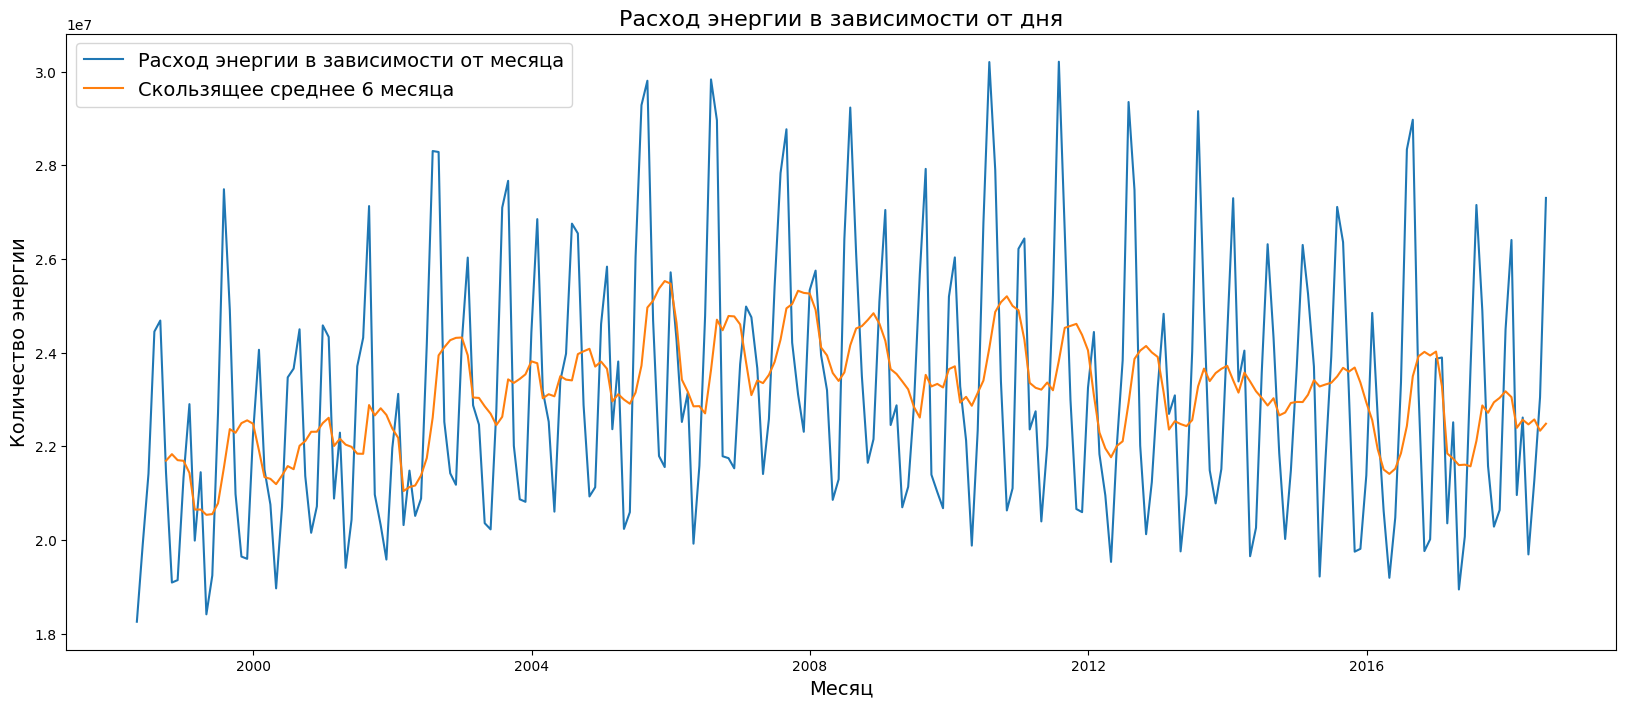

In [307]:
#посмотрим распределение расхода энергии по месяцам на графике со скользящим средним 6 месяцев
plt.figure(figsize=(20,8))
plt.plot(data_pjm_month, label='Расход энергии в зависимости от месяца')
plt.plot(data_pjm_month.rolling(window=6).mean(), label='Скользящее среднее 6 месяца')
plt.legend(title='', loc='upper left', fontsize=14)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество энергии', fontsize=14)
plt.title('Расход энергии в зависимости от дня', fontsize=16)
plt.show();

График скользящего среднего с окном в 6 месяцев частично сглаживает показатели.

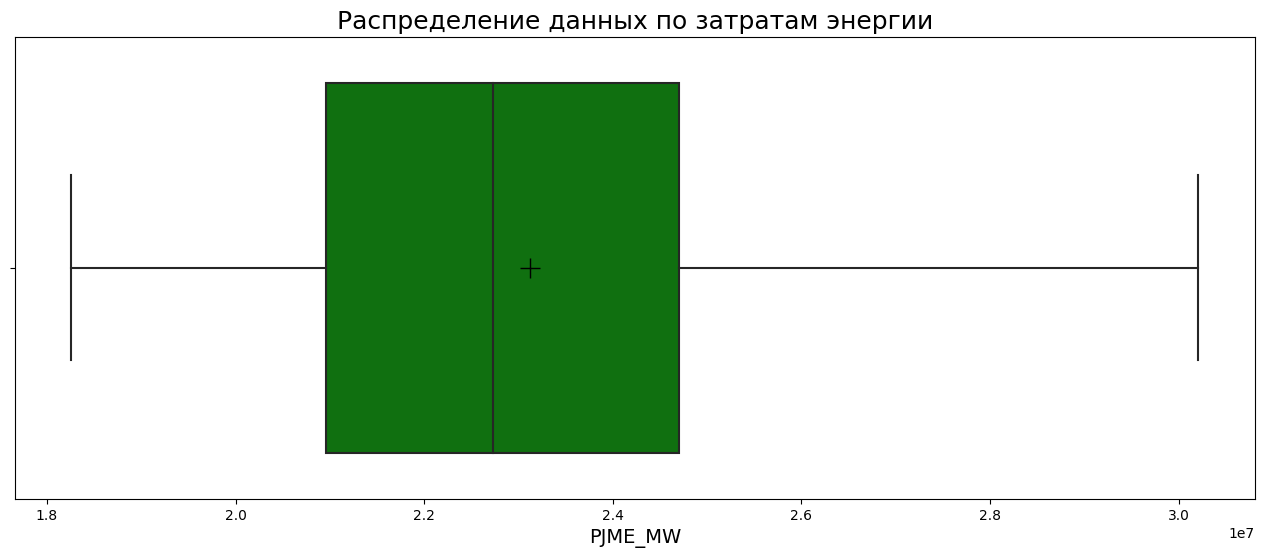

In [308]:
#посмотрим выбросы
plt.figure(figsize=(16, 6))
sns.boxplot(x=data_pjm_month['PJME_MW'], color='green', showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "14"})
plt.xlabel('PJME_MW', size=14)
plt.title('Распределение данных по затратам энергии', size=18);

В процессе увеличения промежутка наблюдения(с часов до месяцев) количество выбросов уменьшается

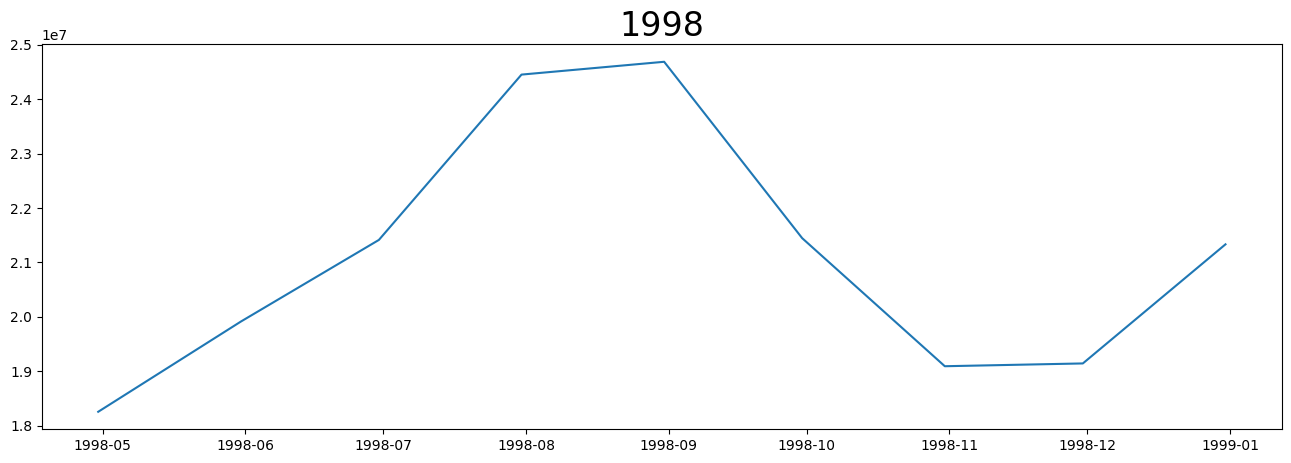

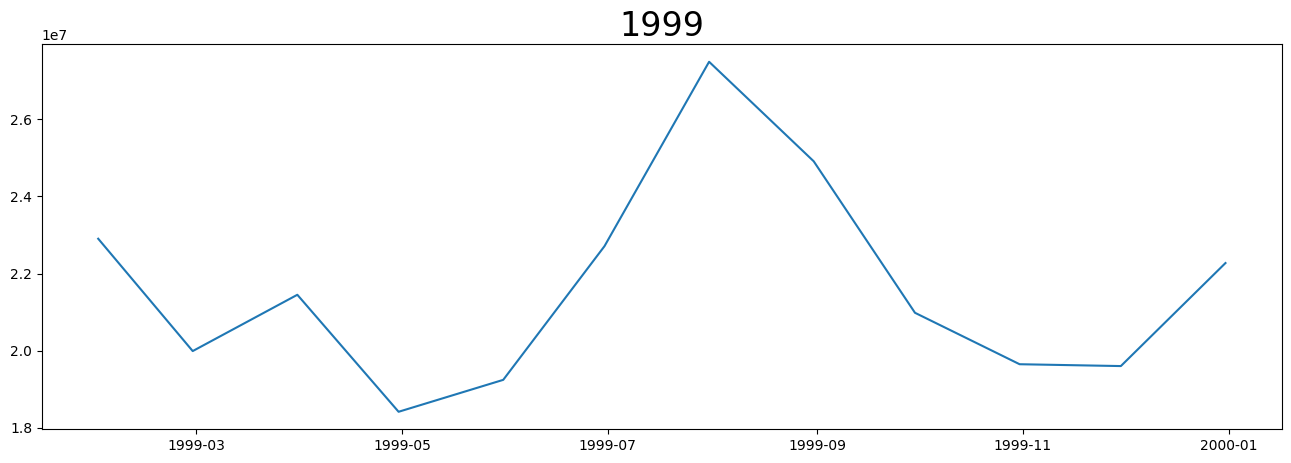

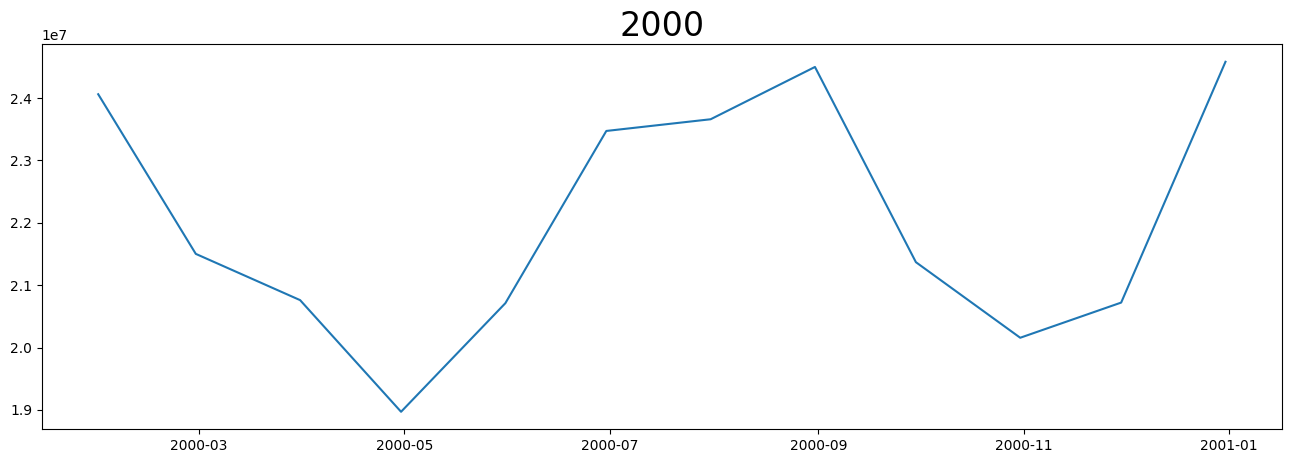

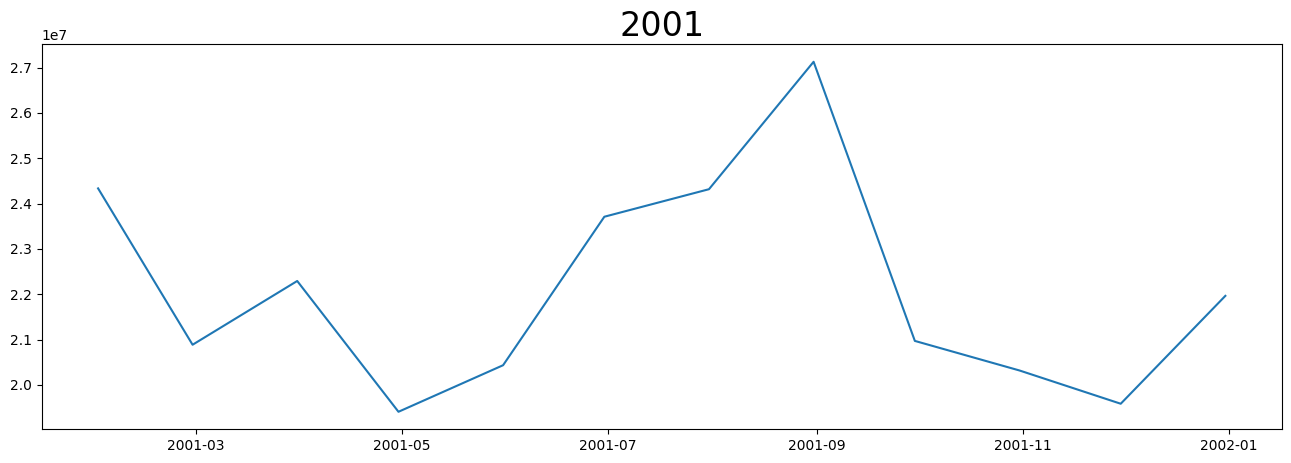

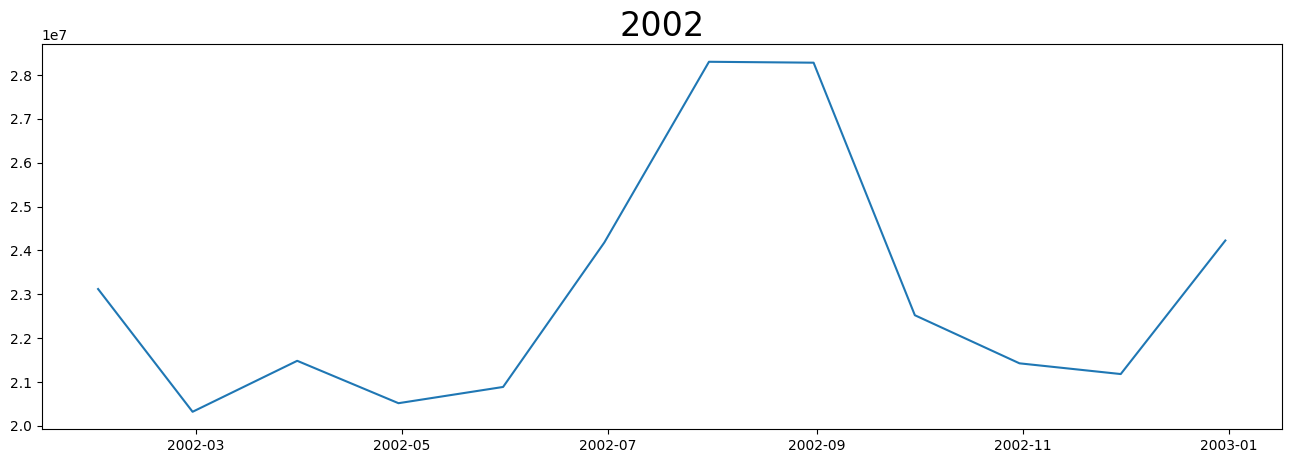

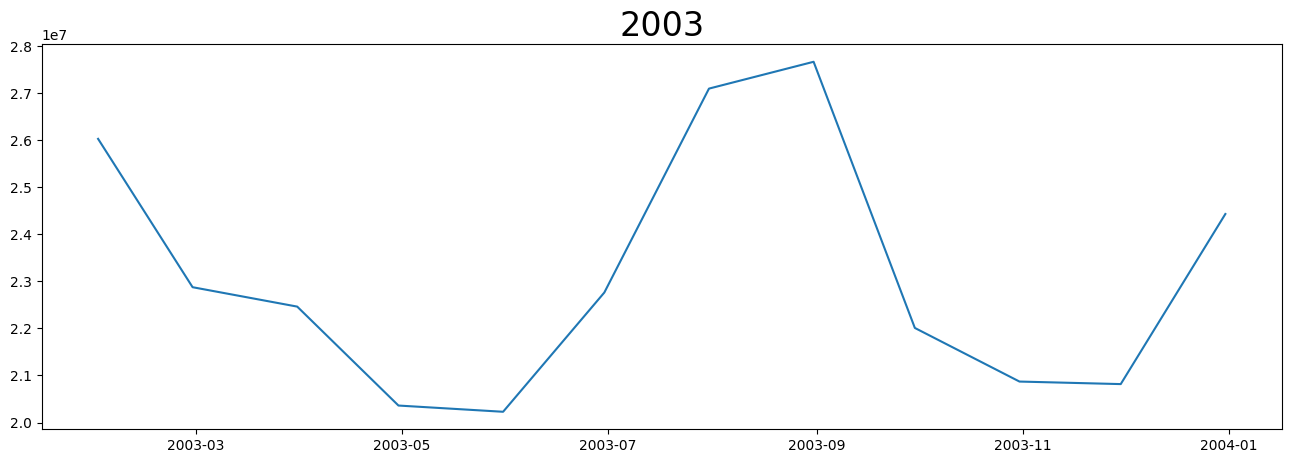

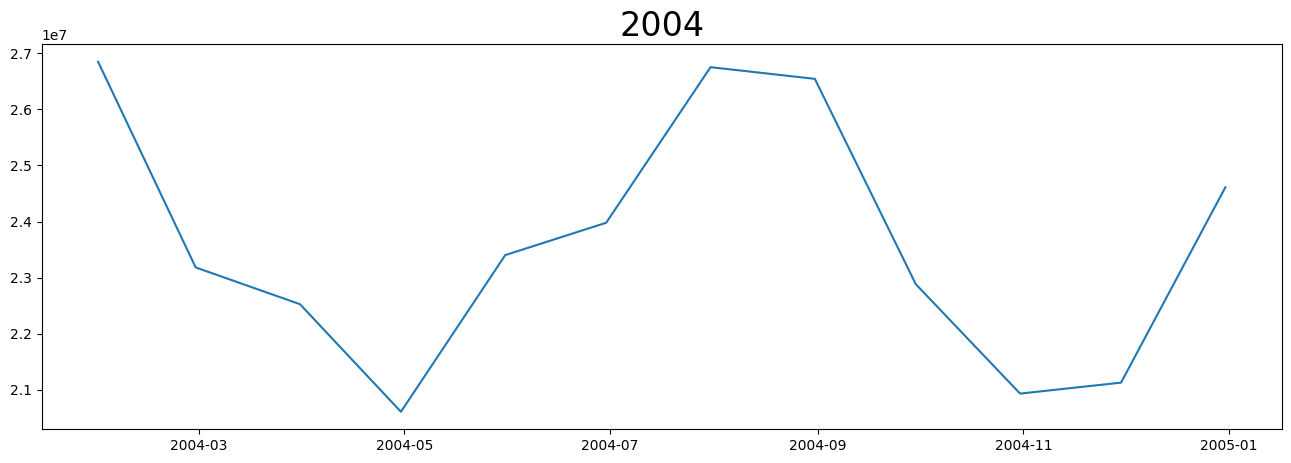

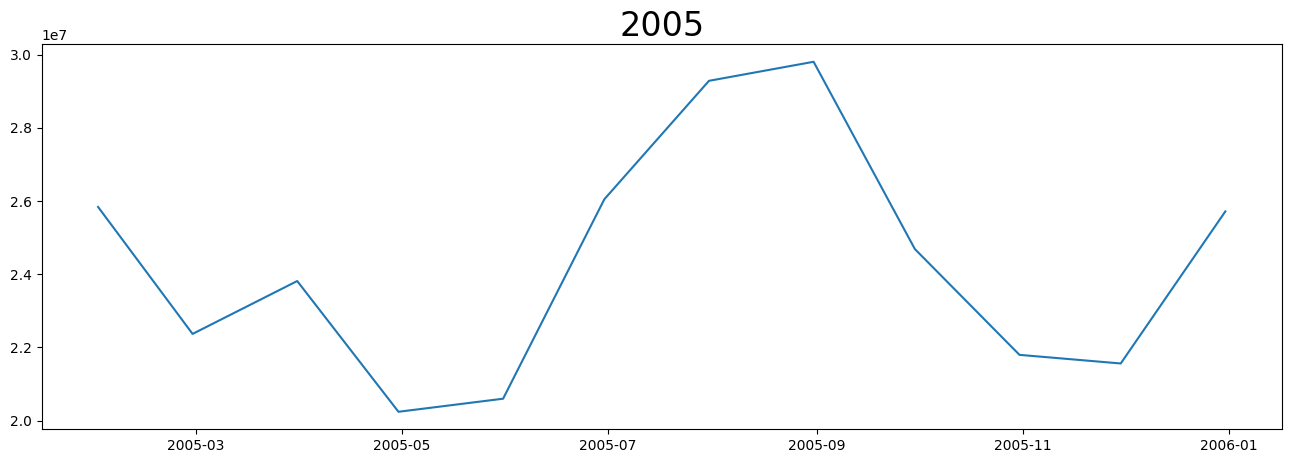

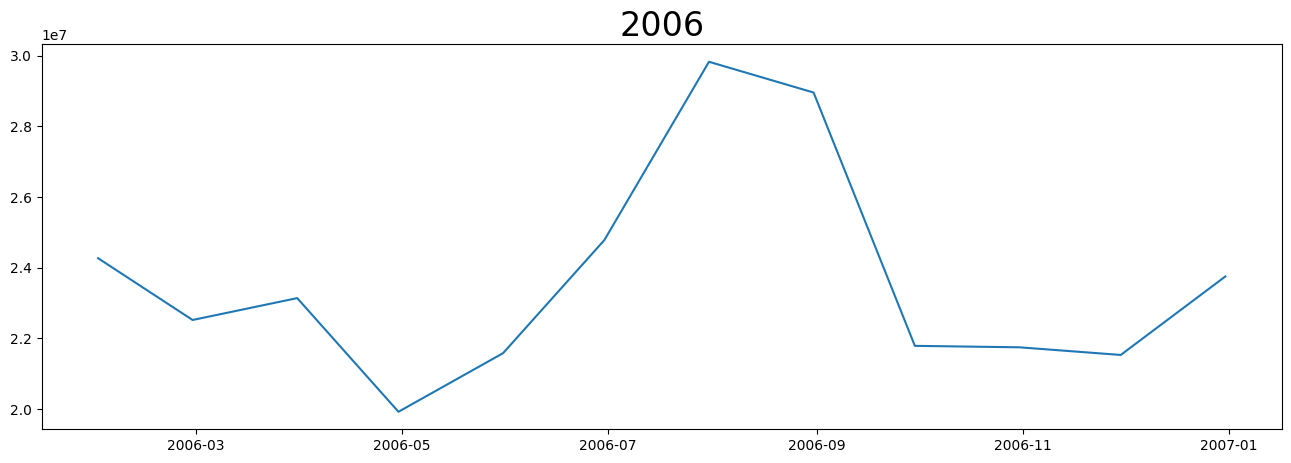

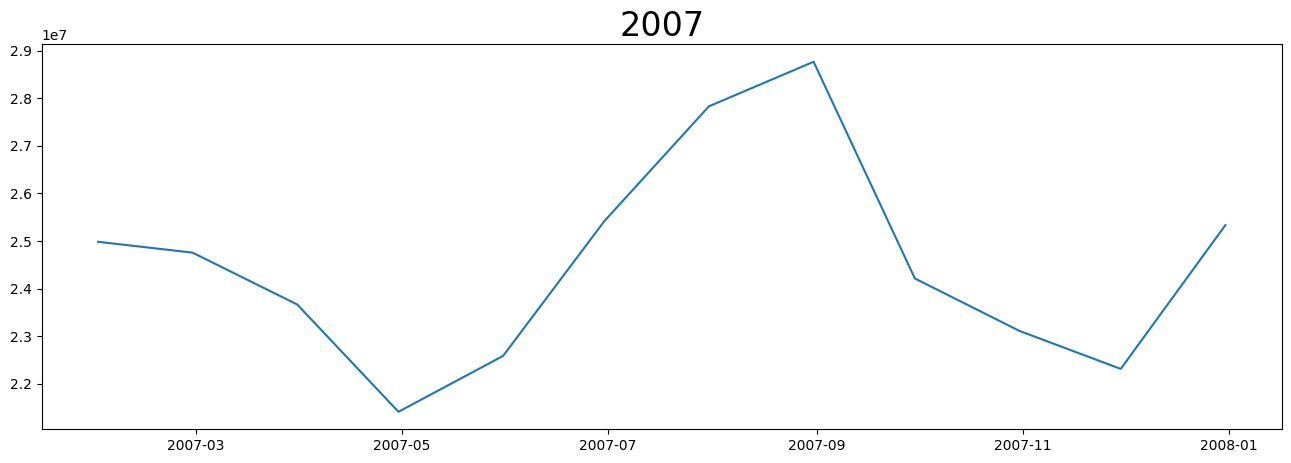

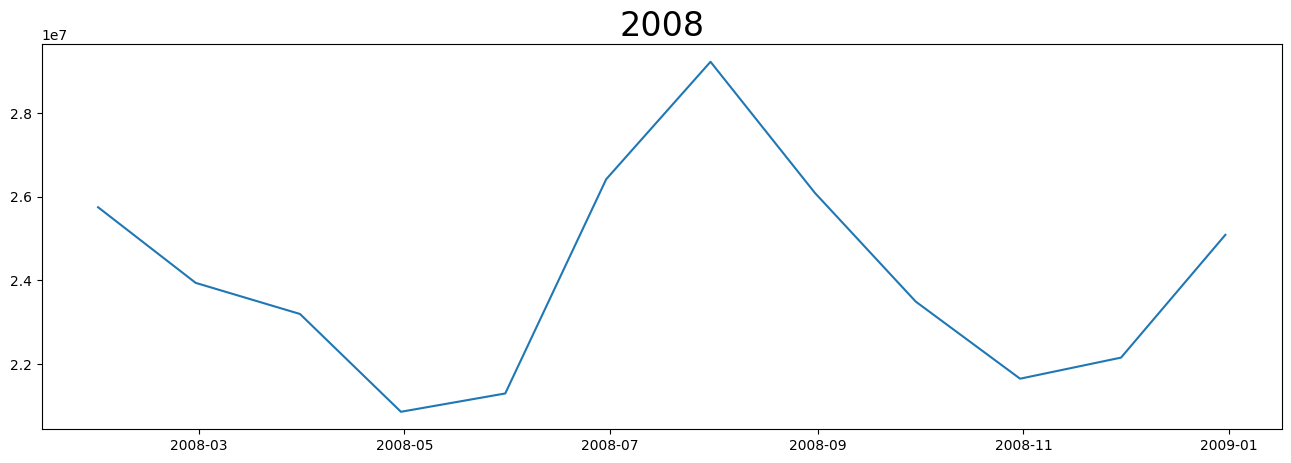

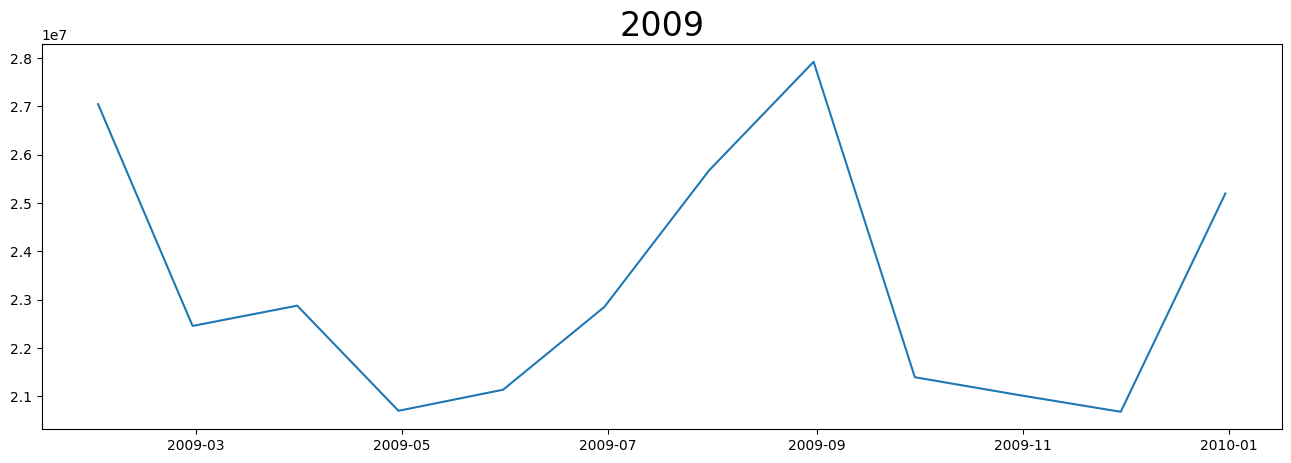

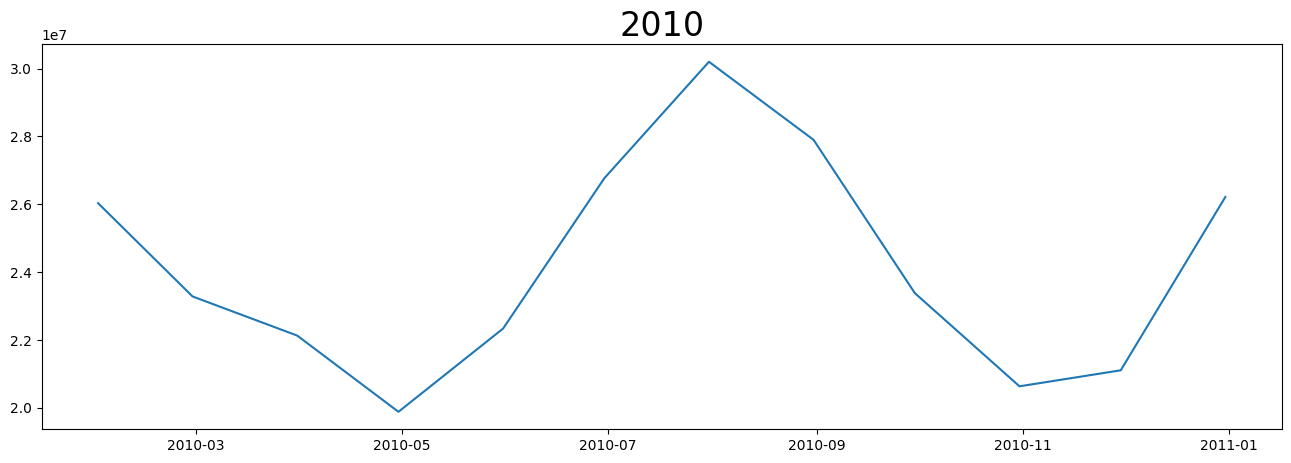

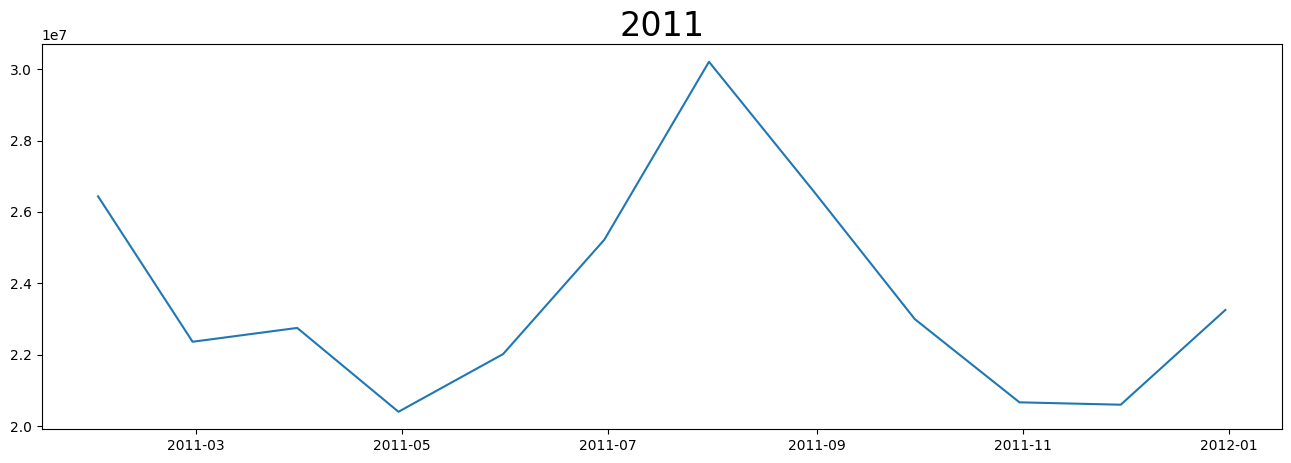

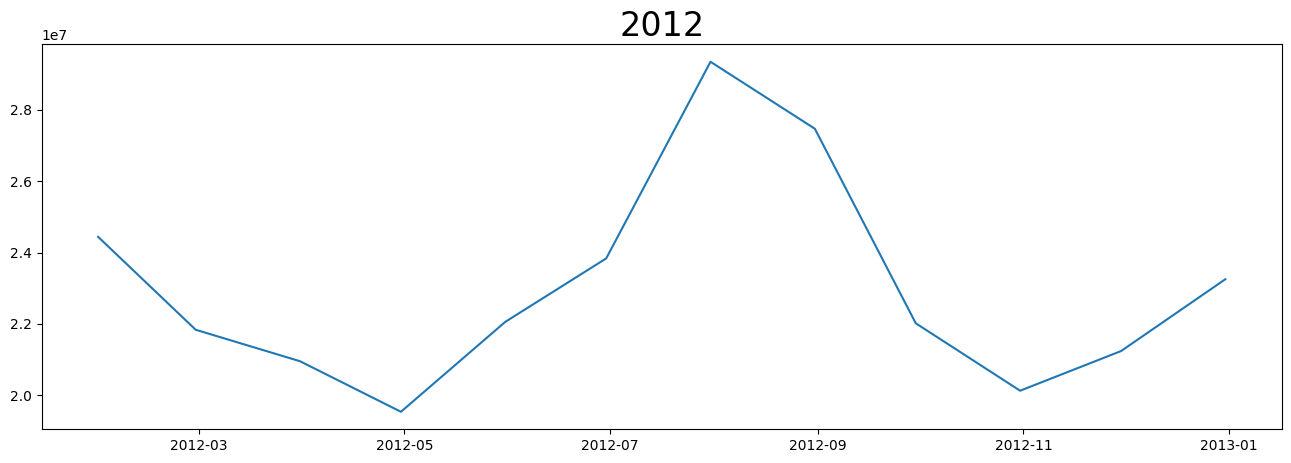

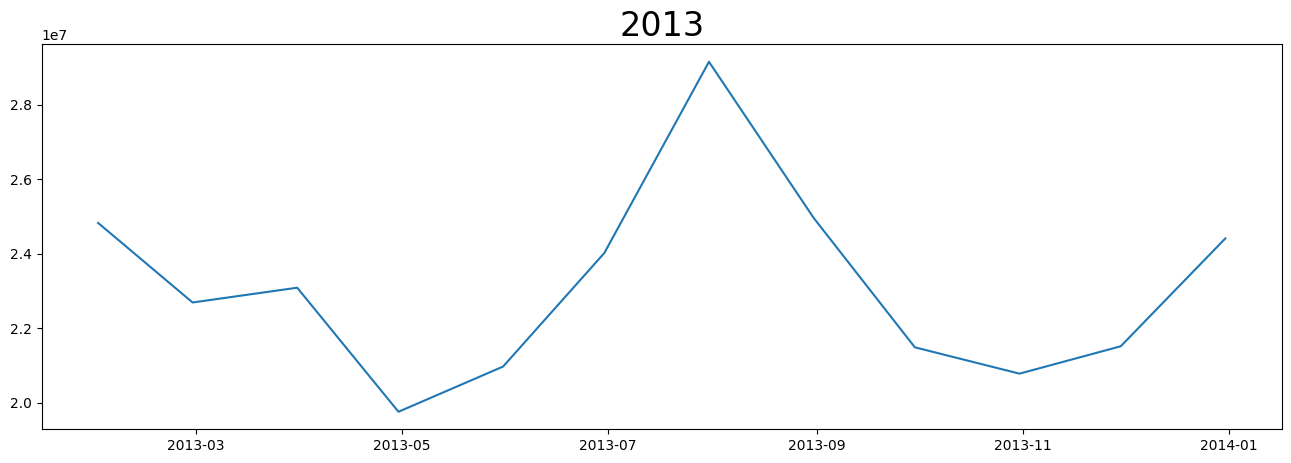

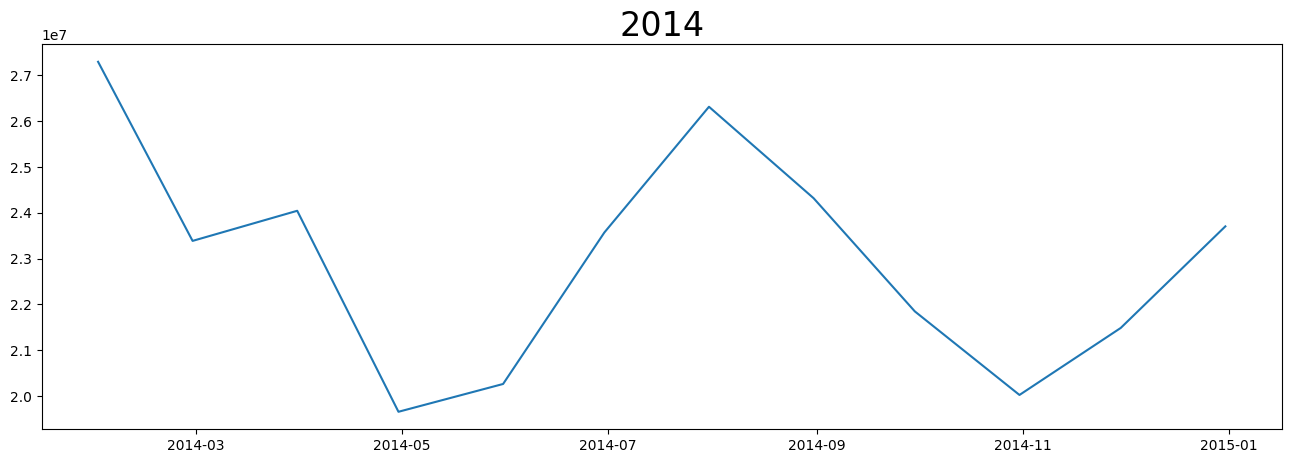

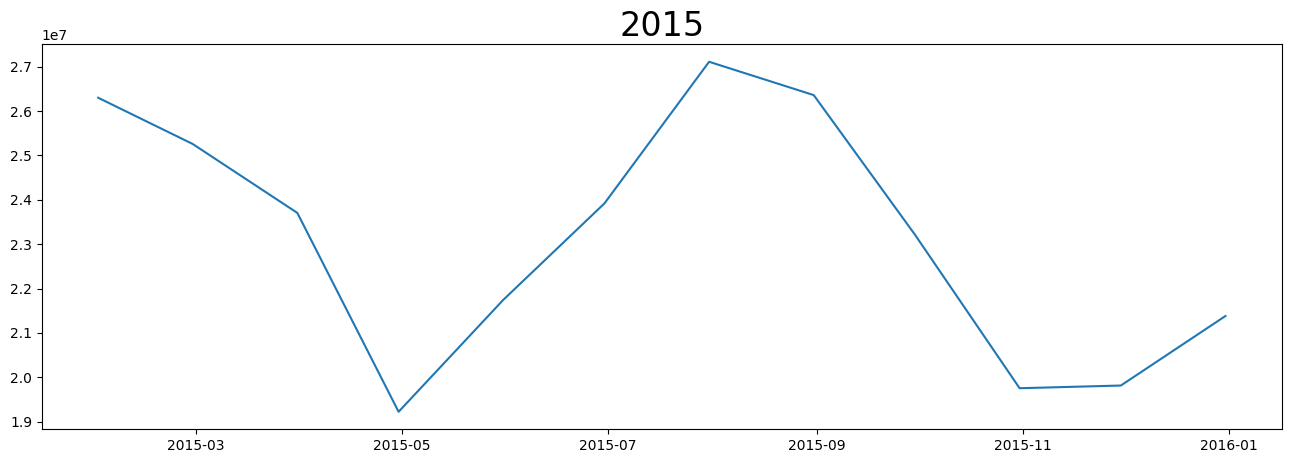

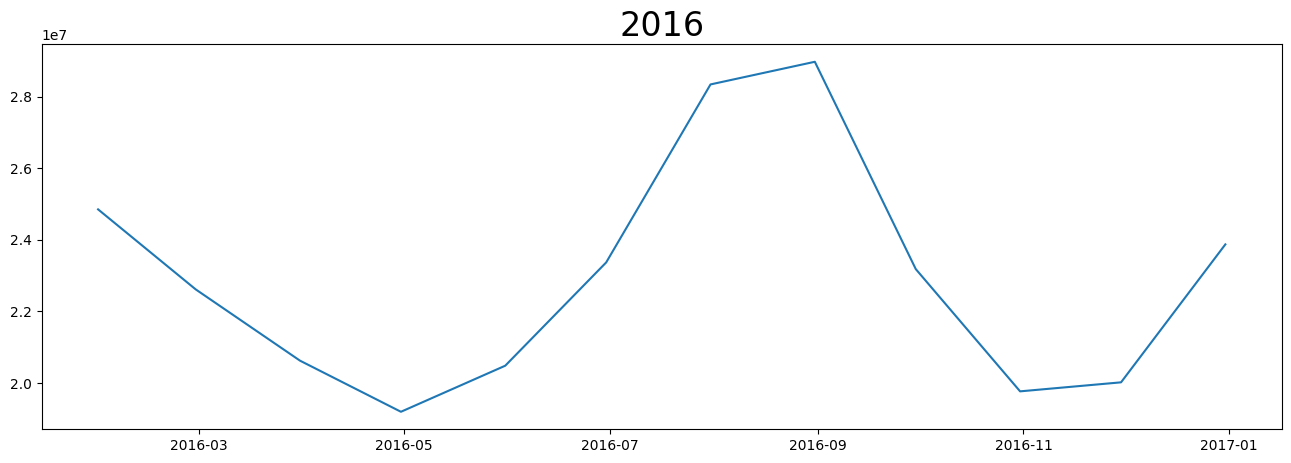

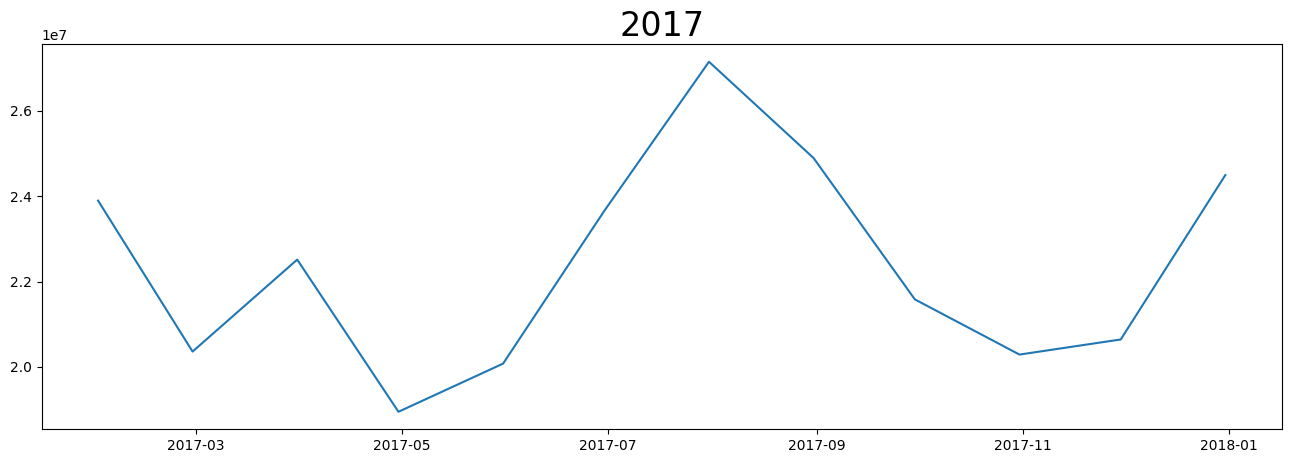

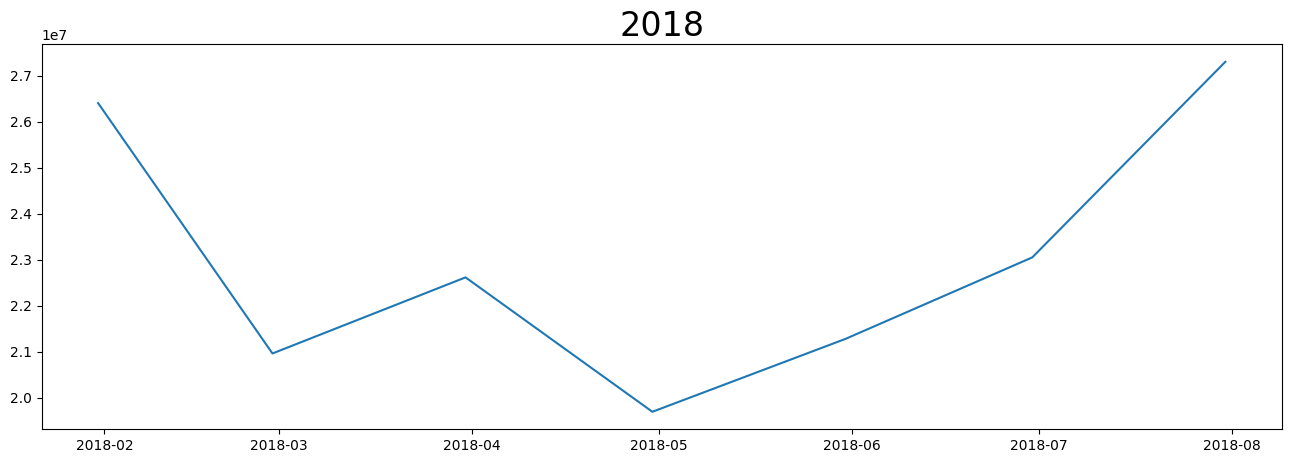

In [309]:
#посмотрим распределение данных по годам
plt.rcParams["figure.figsize"] = 16, 5

for year in set(data_pjm_month.index.year):
    plt.plot(data_pjm_month[["PJME_MW"]].loc[data_pjm_month.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

Пики спада и подема по годам почти совпадают. С началом года идет снижение расхода энергии и достигают первого минимума за год к маю-июню. Потом наблюдается повышение потребления и достигает максимума к августу-сентябрю. Далее происходит второе за год снижение к ноябрю.
В 2000 и 2001 годах наблюжается аномальный скачок в июле.
В 1999, 2008, 2010, 2011, 2013, 2014, 2017 наблюдается один пик в августе, а в 2009 пик в сентябре.

In [310]:
#разделим выборку на обучающюю и тестовую
print(data_pjm_month.sort_index(ascending=True))

train_df = data_pjm_month.loc[:"2014-07-31"]
test_df = data_pjm_month.loc["2014-08-31":]
train_df.shape, test_df.shape

               PJME_MW
Datetime              
1998-04-30  18258202.0
1998-05-31  19914613.0
1998-06-30  21413823.0
1998-07-31  24449999.0
1998-08-31  24685281.0
...                ...
2018-03-31  22615842.0
2018-04-30  19694352.0
2018-05-31  21278364.0
2018-06-30  23050418.0
2018-07-31  27302373.0

[244 rows x 1 columns]


((196, 1), (48, 1))

<function matplotlib.pyplot.show(close=None, block=None)>

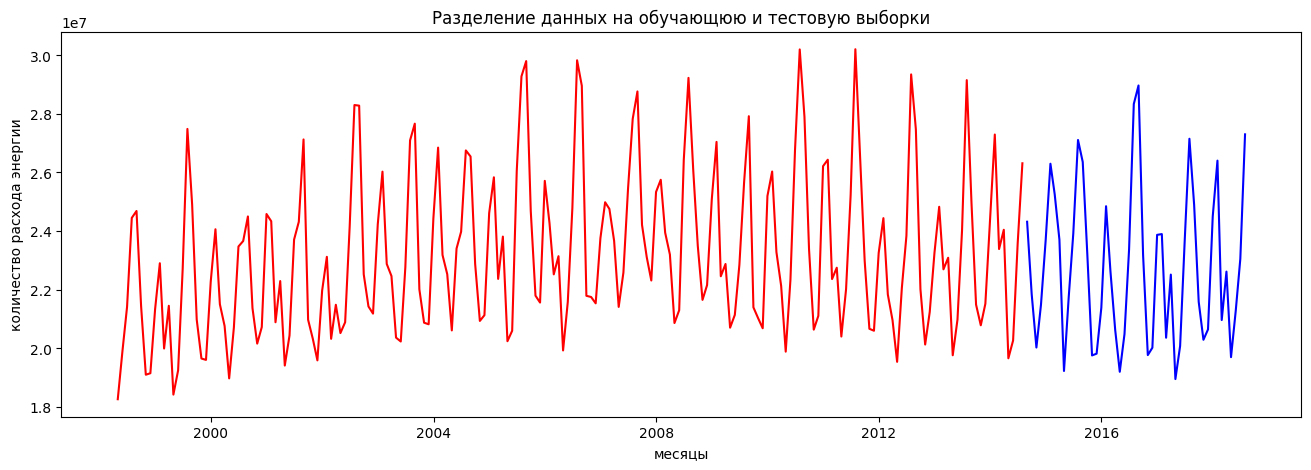

In [311]:
plt.plot(train_df, color='red')
plt.plot(test_df, color='blue')
plt.title('Разделение данных на обучающюю и тестовую выборки')
plt.xlabel('месяцы')
plt.ylabel('количество расхода энергии')
plt.show

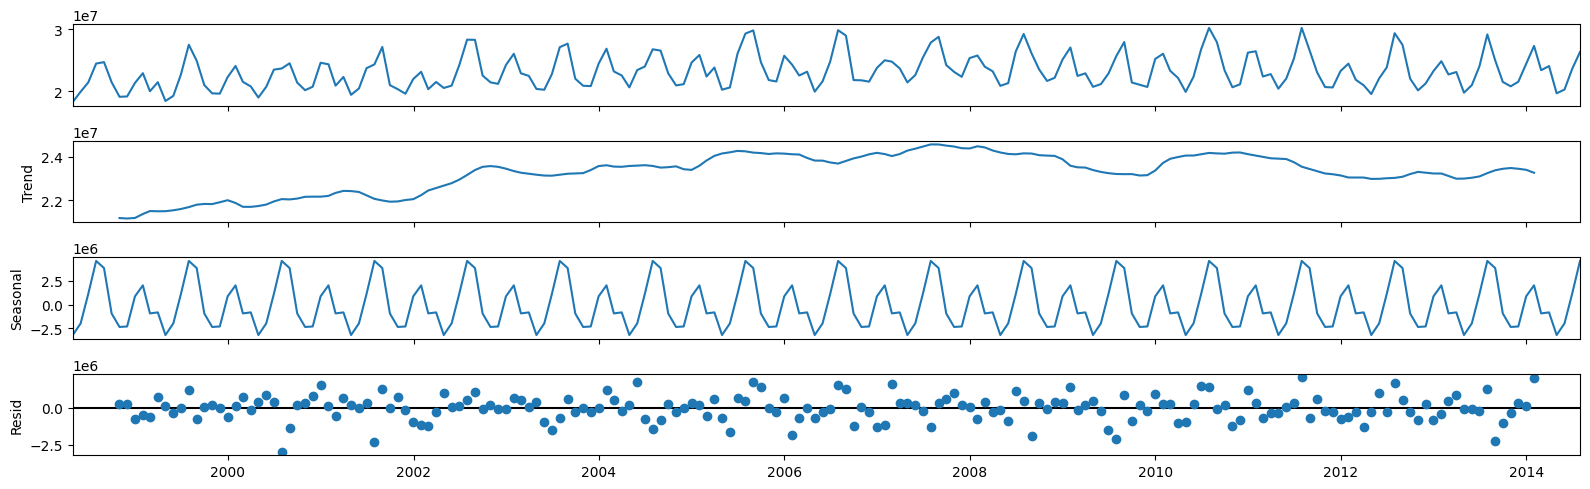

In [312]:
#проведем разложение временного ряда
decompos = seasonal_decompose(train_df)
decompos.plot()
plt.show()

<Axes: xlabel='Datetime'>

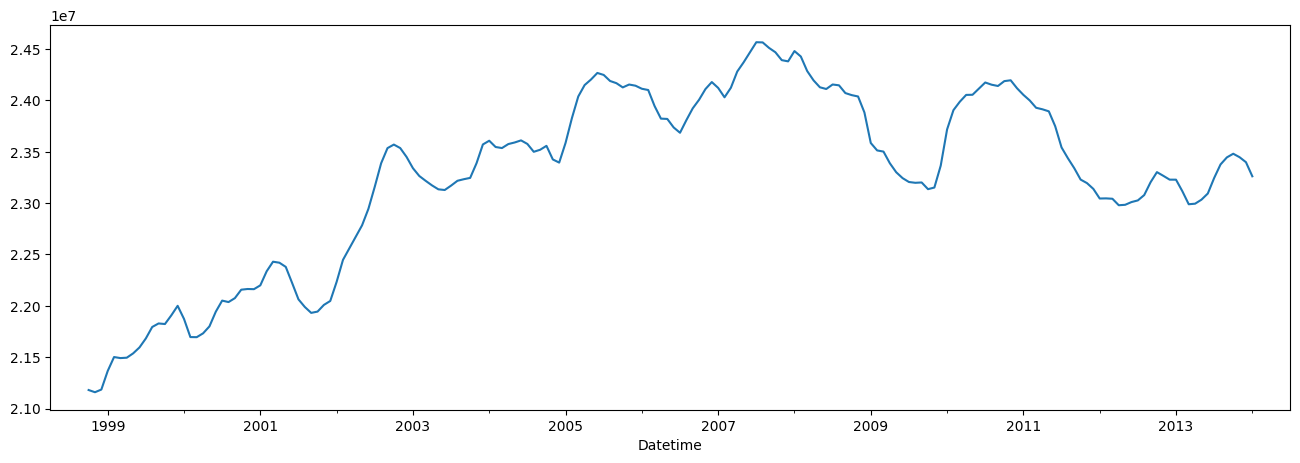

In [313]:
decompos.trend.plot()

Наличие нелинейного тренда

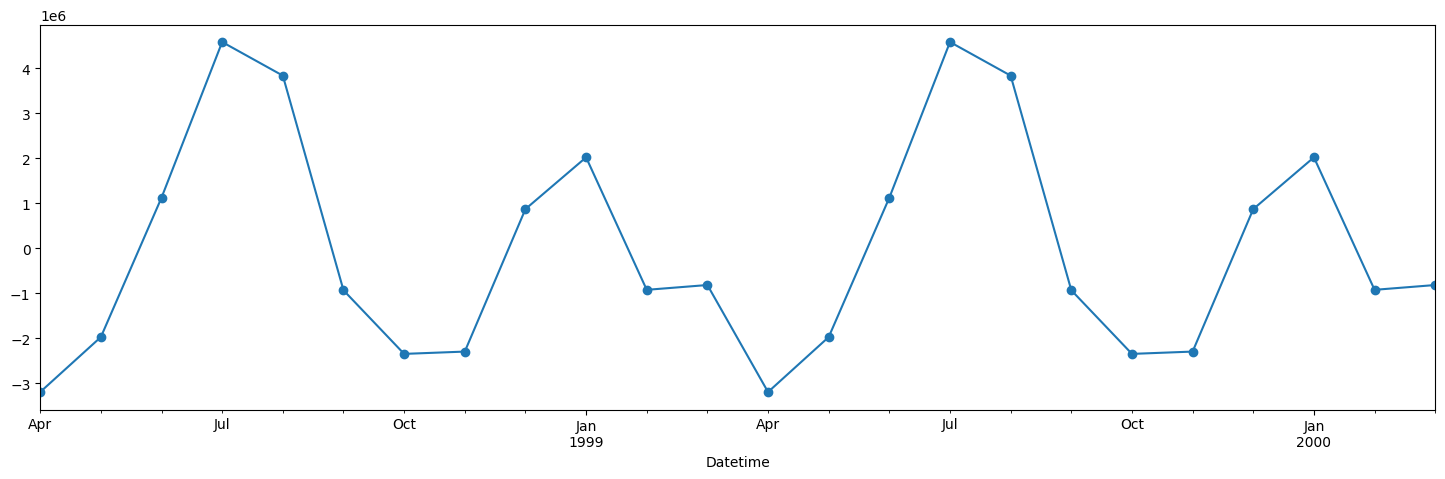

In [346]:
plt.rcParams["figure.figsize"] = 18, 5
decompos.seasonal[:24].plot(marker="o")
plt.show()

Сезонность показывает повторяемость циклов каждые 12 месяцев. 

In [315]:
#проверим временной ряд на стационарность (тест Дики-Фуллера)
def stat_test(df):
    H0 = 'временной ряд нестационарен'
    H1 = 'временной ряд стационарен'
    adf_test = adfuller(df)
    print("adf: ", adf_test[0])
    print("p-value: ", adf_test[1])
    print("usedlag: ", adf_test[2])
    print("nods: ", adf_test[3])
    print("Critical values: ", adf_test[4])
    if adf_test[0] > adf_test[4]["5%"]:
        print(H0)
    else:
        print(H1)
        
stat_test(train_df)

adf:  -2.4801402615360146
p-value:  0.12038148949250388
usedlag:  12
nods:  183
Critical values:  {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}
временной ряд нестационарен


Значение статистики теста больше всех критических значений, поэтому нулевую гипотезу нельзя опровергнуть. Ряд является нестационарным.

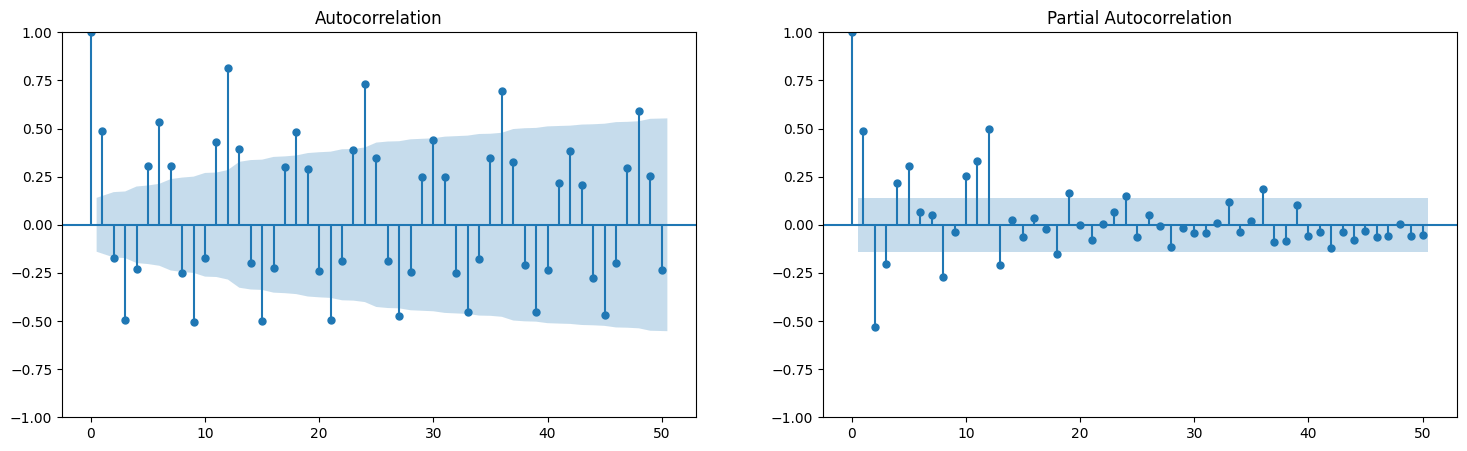

In [316]:
#проведем автокорреляцию
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)
    plot_acf(series, ax=axes[0], lags=50)
    plot_pacf(series, ax=axes[1], lags=50, method="ywm")
    plt.show()
    
plot_acf_pacf(train_df)

График автокорреляции говорит о наличии сезонности. Временной ряд содержит циклическую компоненту k=12, данные являются зависимыми.

adf:  -8.312796181915882
p-value:  3.7494717491116403e-13
usedlag:  11
nods:  183
Critical values:  {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}
временной ряд стационарен


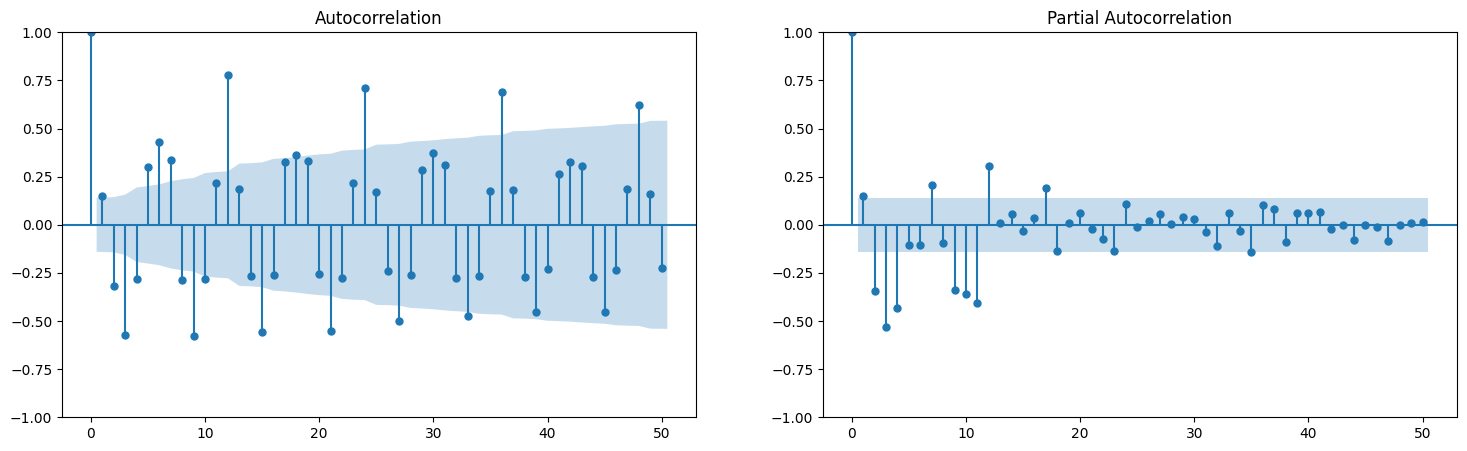

In [317]:
#проведем дифференцирование ряда
train_diff = train_df["PJME_MW"].diff(periods=1).dropna()
stat_test(train_diff)
    
plot_acf_pacf(train_diff)

Значение статистики теста меньше всех критических значений, поэтому можно опровергнуть нулевую гипотезу. Ряд является стационарным.

Первые разности являются стационарными

## Часть 3:  Обучение модели

### Экпотенциальное сглаживание

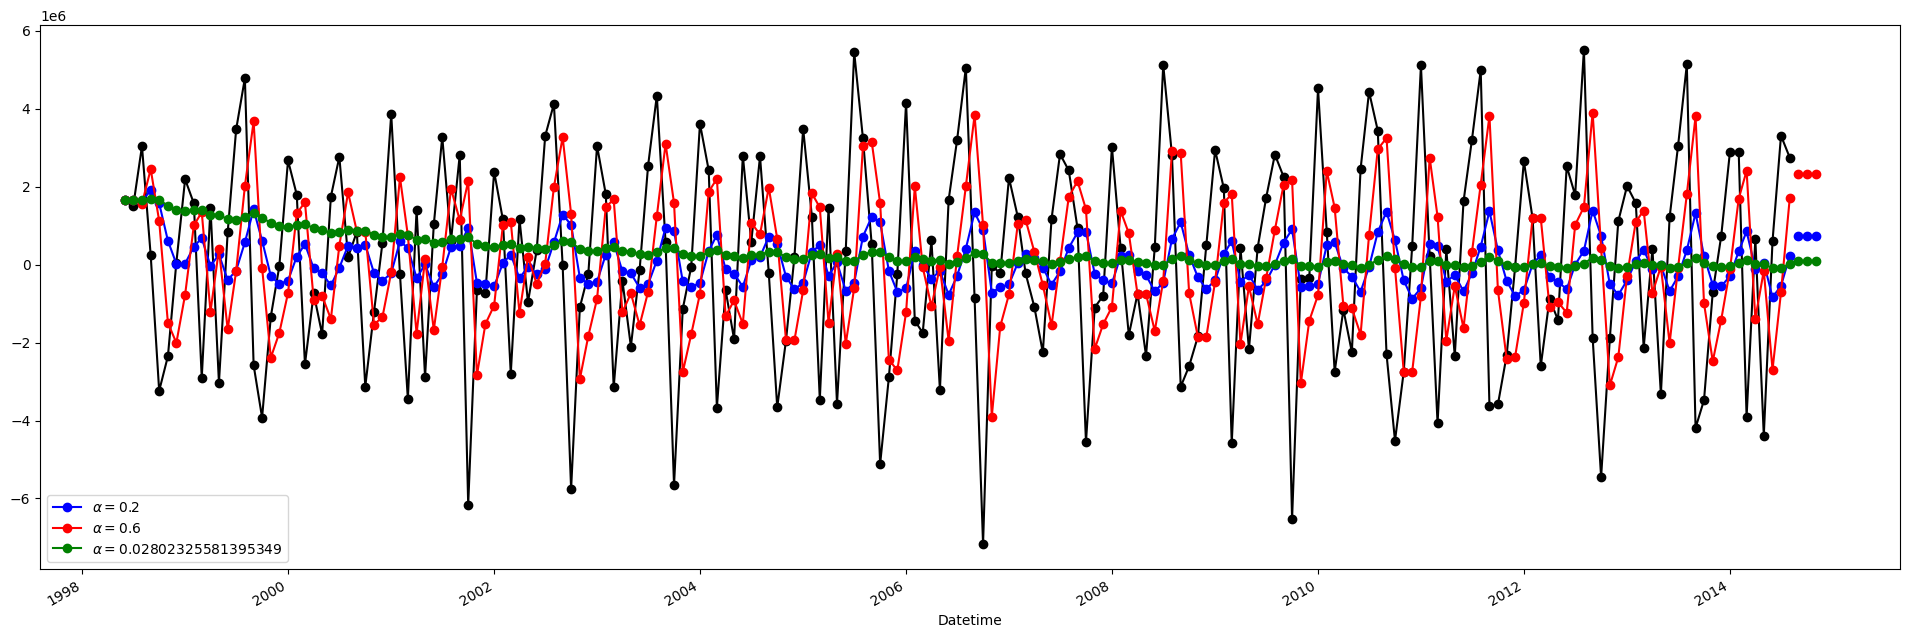

In [318]:
ses1 = SimpleExpSmoothing(train_diff).fit(
    smoothing_level=0.2, 
    optimized=False
)
exp_pred1 = ses1.forecast(3).rename(r"$\alpha=0.2$")

plt.figure(figsize=(24, 8))
plt.plot(train_diff, marker="o", color="black")
exp_pred1.plot(marker='o', color='blue', legend=True)
ses1.fittedvalues.plot(marker='o',  color='blue');

ses2 = SimpleExpSmoothing(train_diff).fit(
    smoothing_level=0.6, 
    optimized=False
)
exp_pred2 = ses2.forecast(3).rename(r"$\alpha=0.6$")
exp_pred2.plot(marker='o', color='red', legend=True)
ses2.fittedvalues.plot(marker='o', color='red');

ses3 = SimpleExpSmoothing(train_diff, initialization_method="estimated").fit()
exp_pred3 = ses3.forecast(3).rename(r"$\alpha=%s$" % ses3.model.params["smoothing_level"])

exp_pred3.plot(marker='o', color='green', legend=True)
ses3.fittedvalues.plot(marker='o',  color='green');


Простое экспотенциальное сглаживание не может давать четкие прогнозы

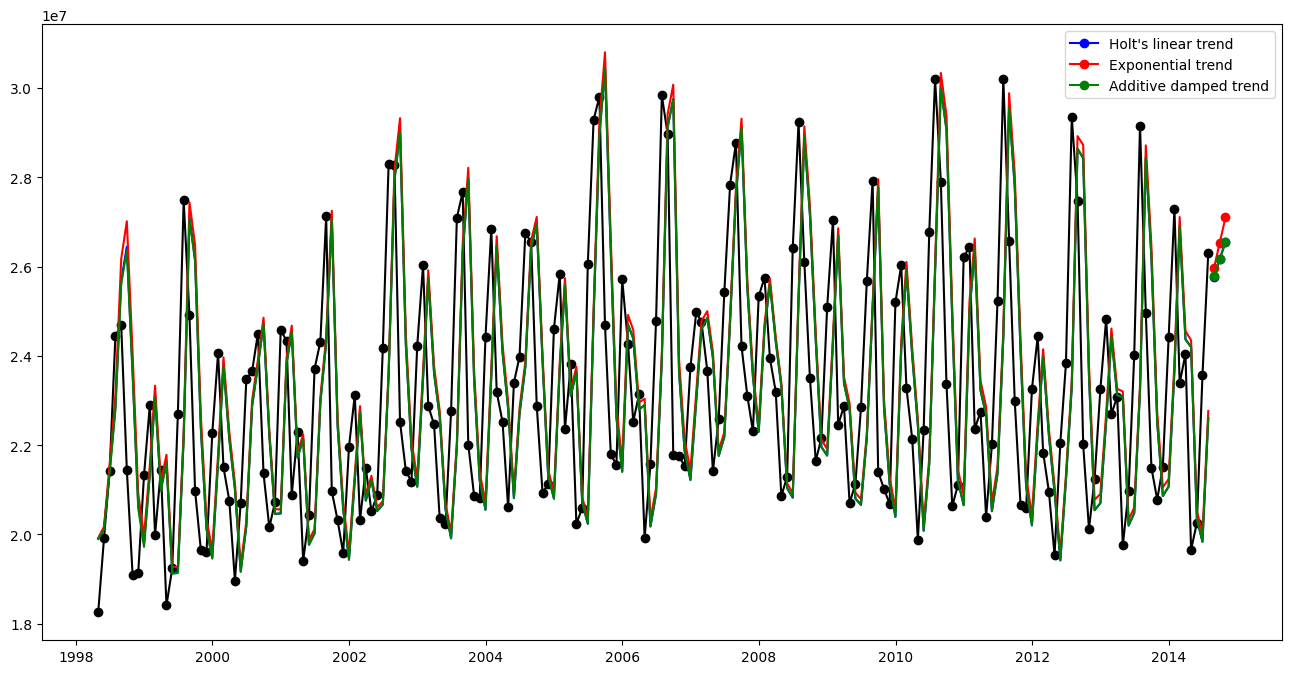

In [319]:
holt1 = Holt(train_df).fit(
    smoothing_level=0.75, 
    smoothing_trend=0.15, 
    optimized=False
)
exph1 = holt1.forecast(3).rename("Holt's linear trend")

holt2 = Holt(train_df, exponential=True).fit(
    smoothing_level=0.75, 
    smoothing_trend=0.15, 
    optimized=False
)
exph2 = holt2.forecast(3).rename("Exponential trend")

holt3 = Holt(train_df, damped_trend=True).fit(
    smoothing_level=0.75, 
    smoothing_trend=0.15
)
exph3 = holt3.forecast(3).rename("Additive damped trend")

plt.figure(figsize=(16, 8))
plt.plot(train_df, marker="o", color="black")
plt.plot(holt1.fittedvalues, color="blue")
(line1,) = plt.plot(exph1, marker="o", color="blue")
plt.plot(holt2.fittedvalues, color="red")
(line2,) = plt.plot(exph2, marker="o", color="red")
plt.plot(holt3.fittedvalues, color="green")
(line3,) = plt.plot(exph3, marker="o", color="green")
plt.legend([line1, line2, line3], [exph1.name, exph2.name, exph3.name]);

Метод Холта лучше справляется с анализом и предсказанием

На основе проведенного исследования данных, попробуем подобрать подходящую модель для построения прогноза. Нам необходимо сделать долгосрочный прогноз для нестационарного ряда, учитывая сезонность.
Для этого можно воспользоваться моделью SARIMA. Если внести поправки на экзогенные переменные, то подойдет модель SARIMAX.

Для моделирования необходимо знать параметры p, d, q, P, D, Q 
Параметр d=1 (у нас интегрированный ряд первого порядка).
Параметр q=10 (определяем по коррелограмме ACF).
Параметр p=4 (определяем по коррелограмме PACF).
Параметр D=1 (порядок интегрированности сезонной разности).
Параметр P=1 (определяем по коррелограмме ACF).
Параметр Q=1 (определяем по коррелограмме PACF).

In [320]:
seas_model = SARIMAX(train_df['PJME_MW'].dropna(), order=(4, 1, 11), seasonal_order=(1, 1, 1, 12))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               PJME_MW   No. Observations:                  196
Model:             SARIMAX(4, 1, 11)x(1, 1, [1], 12)   Log Likelihood               -2832.269
Date:                               Sun, 05 Nov 2023   AIC                           5700.537
Time:                                       12:11:27   BIC                           5758.308
Sample:                                   04-30-1998   HQIC                          5723.955
                                        - 07-31-2014                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2626      0.321     -0.818      0.413      -0.892       0.367
ar.L2         -0.4876      0.350     -1.394      0.163      -1.173       0.198
ar.L3          0.2363      0.339      0.697      0.486      -0.429       0.901
ar.L4         -0.4390      0.275     -1.596      0.111      -0.978       0.100
ma.L1          0.0542      0.308      0.176      0.860      -0.549       0.658
ma.L2          0.3713      0.274      1.353      0.176      -0.166       0.909
ma.L3         -0.4477      0.244     -1.835      0.067      -0.926       0.031
ma.L4          0.4682      0.253      1.850      0.064      -0.028       0.964
ma.L5         -0.1123      0.116     -0.968      0.333      -0.340       0.115
ma.L6          0.0043      0.098      0.044      0.965      -0.188       0.197
ma.L7          0.0549      0.081      0.681      0.496      -0.103       0.213
ma.L8         -0.0475      0.079     -0.599      0.549      -0.203       0.108
ma.L9         -0.0188      0.071     -0.265      0.791      -0.158       0.120
ma.L10        -0.0303      0.073     -0.415      0.678      -0.174       0.113
ma.L11         0.2280      0.098      2.324      0.020       0.036       0.420
ar.S.L12       0.1950      0.144      1.354      0.176      -0.087       0.477
ma.S.L12      -0.6868      0.105     -6.563      0.000      -0.892      -0.482
sigma2      1.736e+12   2.41e-13   7.19e+24      0.000    1.74e+12    1.74e+12
===================================================================================
Ljung-Box (L1) (Q):                   5.38   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.02   Prob(JB):                         0.57
Heteroskedasticity (H):               0.77   Skew:                            -0.17
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.82e+40. Standard errors may be unstable.
"""

In [321]:
#проведем автоматический подбор параметров для модели
parametr = auto_arima(train_df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,
                      D=1, trace=True, error_action='ignore', suppresss_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5703.817, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5755.487, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5726.700, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5706.149, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5744.206, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5700.296, Time=0.20 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5719.020, Time=0.18 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5700.971, Time=0.72 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5701.485, Time=1.19 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5699.486, Time=0.97 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5702.011, Time=0.68 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5708.332, Time=0.56 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=5698.979, Time=1.15 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5703.516, Time=0.40 sec
 ARIMA(2,1,1)(1,1,2

In [322]:
best_model = SARIMAX(train_df['PJME_MW'].dropna(), order=(2, 1, 0), seasonal_order=(0, 1, 2, 12))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                 PJME_MW   No. Observations:                  196
Model:             SARIMAX(2, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2844.368
Date:                                 Sun, 05 Nov 2023   AIC                           5698.736
Time:                                         12:11:42   BIC                           5714.783
Sample:                                     04-30-1998   HQIC                          5705.240
                                          - 07-31-2014                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1889      0.038     -4.971      0.000      -0.263      -0

## Часть 4:  Тестирование модели

In [323]:
#предсказание для лучшей модели, выбранной по автоматическому подбору параметров
start = len(train_df)
end = len(train_df) + len(test_df) - 1
test_df_pred = best_model_fit.predict(start, end)
test_df_pred.head()

2014-08-31    2.348451e+07
2014-09-30    1.977274e+07
2014-10-31    1.843475e+07
2014-11-30    1.895299e+07
2014-12-31    2.197914e+07
Freq: M, Name: predicted_mean, dtype: float64

In [324]:
#предсказание для сезонной модели, выбранной по ручному подбору параметров
start = len(train_df)
end = len(train_df) + len(test_df) - 1
test_df_pred1 = seas_model_fit.predict(start, end)
test_df_pred1.head()

2014-08-31    2.425491e+07
2014-09-30    2.037687e+07
2014-10-31    1.905784e+07
2014-11-30    1.971372e+07
2014-12-31    2.292564e+07
Freq: M, Name: predicted_mean, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

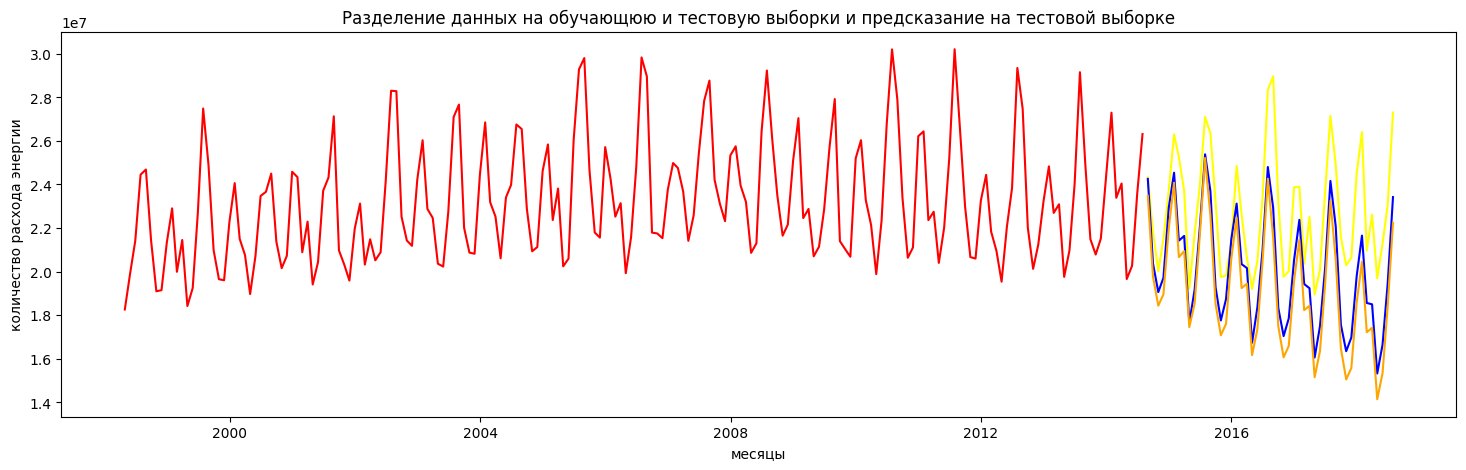

In [325]:
plt.plot(train_df, color='red')
plt.plot(test_df, color='yellow')
plt.plot(test_df_pred1, color='blue')
plt.plot(test_df_pred, color='orange')
plt.title('Разделение данных на обучающюю и тестовую выборки и предсказание на тестовой выборке')
plt.xlabel('месяцы')
plt.ylabel('количество расхода энергии')
plt.show

In [326]:
#расчитаем среднеквадратическую и квадрат MSE
MSE = metrics.mean_squared_error(test_df, test_df_pred)
RMSE = np.sqrt(metrics.mean_squared_error(test_df, test_df_pred))
print(MSE, RMSE, sep='\n')

15153878228520.484
3892798.2517105206


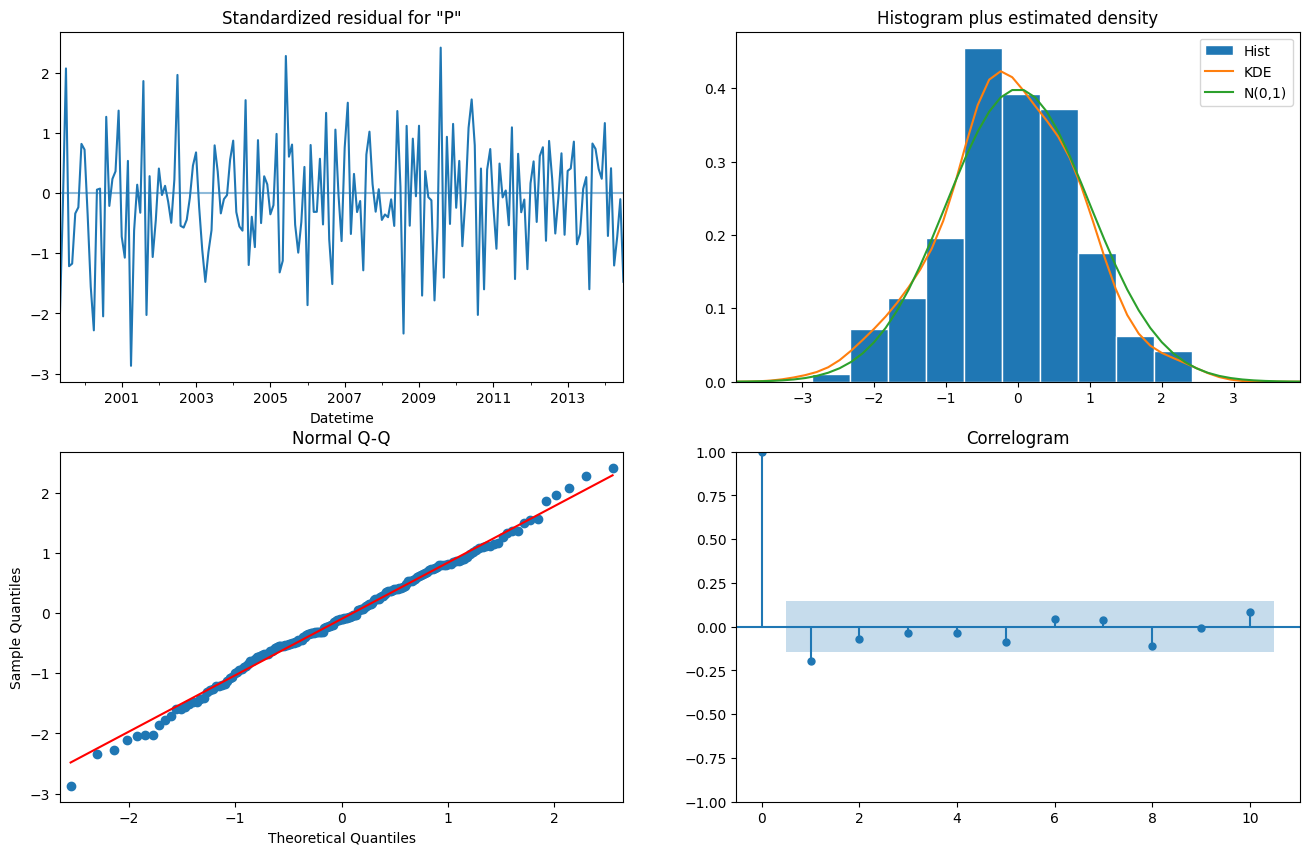

In [327]:
best_model_fit.plot_diagnostics(figsize=(16,10));

Остатки во времени (верхний левый график) не проявляют явной сезонности и кажутся белым шумом.

На верхнем правом графике видно, что красная линия KDE близко следует за линией N(0,1) (где N(0,1) - это стандартное обозначение для нормального распределения со средним 0 и стандартное отклонение 1). Это признак того, что остатки обычно распределяются.

QQ-plot в нижнем левом углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного нормального распределения с N(0, 1). Это тоже признак того, что остатки обычно распределяются.

Коррелограмма (график в правом нижнем углу) показывает, что остатки временного ряда имеют низкую автокорреляцию.

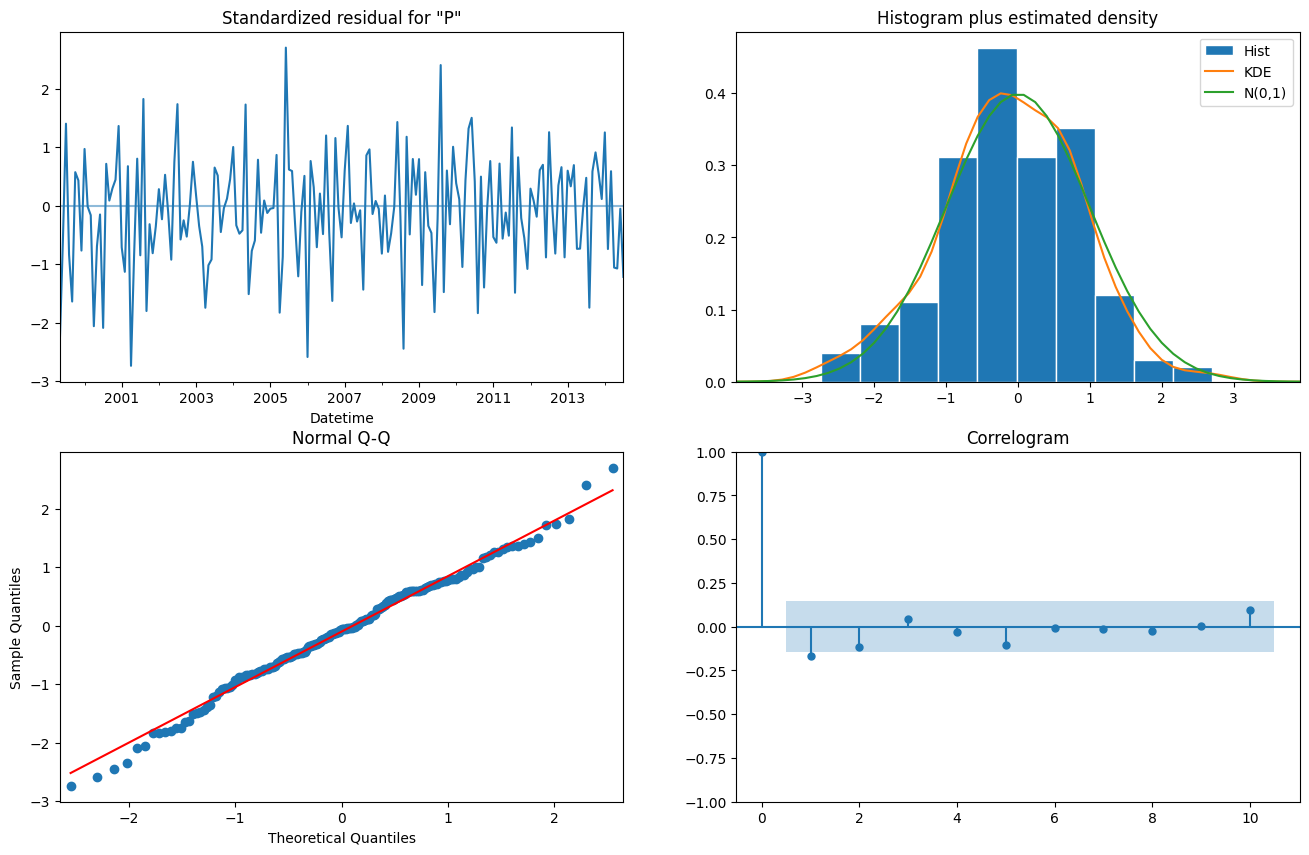

In [328]:
seas_model_fit.plot_diagnostics(figsize=(16,10));

Графики KDE и N(0,1) более близки подходят друг к другу, чем в в модели выше.

In [329]:
#расчитаем среднеквадратическую и квадрат MSE
MSE1 = metrics.mean_squared_error(test_df, test_df_pred1)
RMSE1 = np.sqrt(metrics.mean_squared_error(test_df, test_df_pred1))
print(MSE1, RMSE1, sep='\n')

9016497886338.684
3002748.3887829636


In [330]:
#сравним ошибки двух моделей
print(MSE > MSE1)
print(RMSE > RMSE1)

True
True


На визуализации выборок и предсказаний видно, что модель seas_model показывает более близкие значения с оригиналом, чем best_model.
Среднеквадратическая и квадрат среднеквадратической ошибки больше у best_model.
На основании сделанных выводов, я выберу для прогноза модель с ручным подбором данных saea_model_fit.

## Часть 5:  Прогнозирование временных рядов

In [351]:
#сделаем предсказание на 5 лет
start = len(data_pjm_month)
end = (len(data_pjm_month) - 1) + 5*12

forecast = seas_model_fit.predict(start, end)
forecast.head(12)

2018-08-31    2.124519e+07
2018-09-30    1.685476e+07
2018-10-31    1.557645e+07
2018-11-30    1.615798e+07
2018-12-31    1.907050e+07
2019-01-31    2.087022e+07
2019-02-28    1.776001e+07
2019-03-31    1.778334e+07
2019-04-30    1.453222e+07
2019-05-31    1.585652e+07
2019-06-30    1.872912e+07
2019-07-31    2.262768e+07
Freq: M, Name: predicted_mean, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

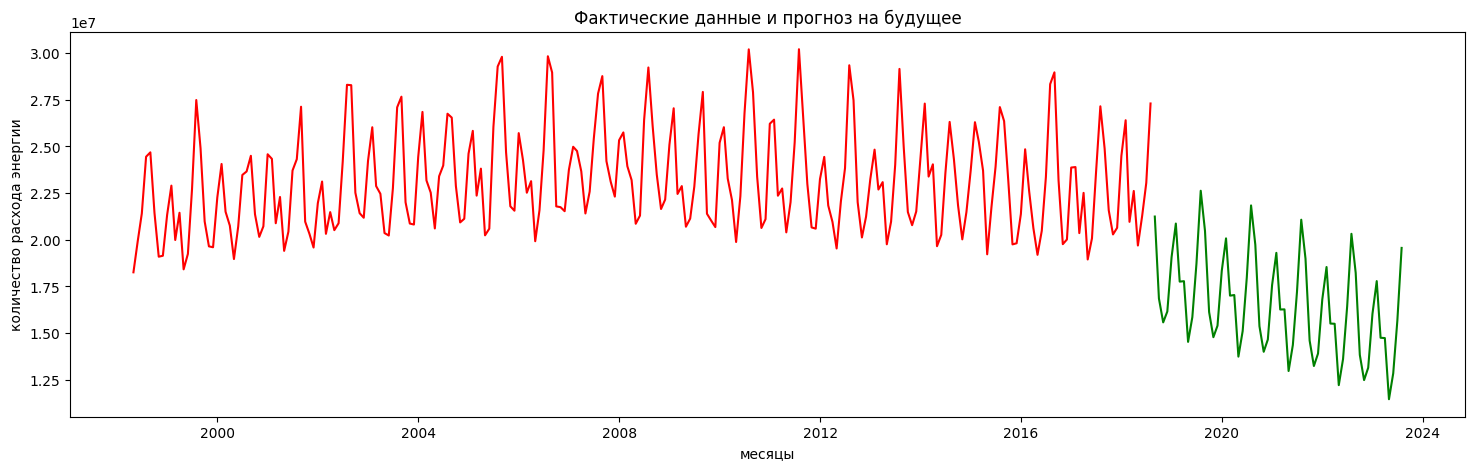

In [352]:
#визуализируем прогноз для двух моделей
plt.plot(data_pjm_month, color='red')
plt.plot(forecast, color='green')
plt.title('Фактические данные и прогноз на будущее')
plt.xlabel('месяцы')
plt.ylabel('количество расхода энергии')
plt.show

## Выводы:
1. После проведенного анализа данных о расходе энергии по  месяцам выявляется небольшой нелинейный тренд и годичная сезонность. Наблюдаются подъемы расхода в летние и зимние месяцы и спады весной и осенью.
Пик потребления приходиться на июль, второй пик на - январь. Минимальные значения определяются в апреле и октябре.

2. За 20 лет наблюдений наблюдается небольшой нелинейный тренд. В первые 10 лет определяется подъем потребления энергии, а вторые 10 лет идет почти симметричный спад.

3. На основании предсказания о расходе энергии на 5 лет, можно сделать вывод о том, что модель хорошо справляется с предсказаними по месяцам (хорошо отслеживается сезонность).Что касается предсказаний на годы, то наблюдается стойкое снижение тренда. А этого на реальных данных не происходит. Модель не уловила тренда изменений по годам.